# Tech Challenge | Fase 2 - Previsão da Tendência do IBOVESPA

Este notebook documenta o projeto da Fase 2 da Pós-Tech FIAP em Data Analytics. O desafio propõe a aplicação prática de técnicas de análise de dados e aprendizado de máquina para resolver um problema real do mercado financeiro.

## Cenário

Neste desafio, assumo o papel de <font color="#20B2AA">**Cientistas de Dados**</font> atuando em um grande fundo de investimentos brasileiro. Nosso objetivo é desenvolver um modelo capaz de prever se o índice **IBOVESPA** fechará em <font color="#20B2AA">**alta**</font> ou <font color="#20B2AA">**baixa**</font> no dia seguinte, com base em dados históricos.

A previsão será usada como apoio a dashboards internos da área de análise quantitativa, oferecendo mais uma camada de suporte à tomada de decisão dos analistas do fundo.

## Fonte de Dados

Os dados foram obtidos diretamente do Yahoo Finance (`yfinance`) utilizando o ticker `^BVSP`, que representa o índice IBOVESPA. O dataset contempla informações diárias como abertura, fechamento, máxima, mínima e volume, com recorte até a data de 31/07/2025.

## Objetivo

Construir e avaliar modelos preditivos capazes de antecipar a direção (alta ou baixa) do fechamento do IBOVESPA no dia seguinte (T+1), testando também variações para T+2 e T+5. Foram exploradas diferentes janelas de treino (2 a 25 anos) e algoritmos supervisionados de classificação binária e multiclasse, buscando maximizar o F1-Score e a robustez do modelo em cenários reais.

## Estrutura do Notebook

O notebook está estruturado da seguinte forma:
- Preparação do ambiente e aquisição dos dados
- Pré-processamento e limpeza
- Engenharia de features (lags, retornos, médias móveis, etc.)
- Criação de targets (T+1, T+2, T+5 e 3 classes)
- Separação treino/teste com lógica temporal (últimos 30 dias)
- Testes com diferentes janelas de treino
- Aplicação de diversos modelos (XGBoost, LightGBM, Random Forest, SVM e Regressão Logística)
- Ajuste de cutoffs e ensemble de modelos
- Avaliação de métricas e seleção da melhor abordagem

## Requisitos Técnicos e Entregas

Este projeto segue os requisitos definidos no desafio: criação de features, aplicação de modelos supervisionados, análise de resultados, trade-offs entre métricas, e apresentação final com vídeo explicativo. 

## Dicionário de Dados

| Coluna              | Descrição                                                  |
|---------------------|-------------------------------------------------------------|
| `abertura`          | Preço de abertura do IBOVESPA no dia                       |
| `fechamento`        | Preço de fechamento do dia                                 |
| `maxima`            | Preço máximo do dia                                        |
| `minima`            | Preço mínimo do dia                                        |
| `volume`            | Volume financeiro negociado                                |
| `retorno_1d`, `2d`, `5d` | Retornos percentuais com 1, 2 e 5 dias de defasagem         |
| `log_diff_lag_X`    | Diferença logarítmica defasada em X dias                   |
| `media_movel_5`     | Média móvel simples de 5 dias                              |
| `target`, `target_t2`, `target_t5` | Targets binários (T+1, T+2, T+5) para classificação       |
| `target_3_classes`  | Target multiclasse baseado em variação de ±0.5% e ±0.2%     |


## **CONFIGURAÇÃO DOS DADOS**

In [32]:

# Bibliotecas essenciais
import pandas as pd
import numpy as np
import calendar  # Manipulação de datas
from datetime import date  # Datas específicas
import yfinance as yf  # Coleta de dados da Bolsa

# Modelos de séries temporais
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Pré-processamento de dados
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Modelagem e otimização
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Avaliação de desempenho
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Salvamento de modelos
from joblib import dump, load


In [3]:
# Configurações de visualização para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]

## **AQUISIÇÃO E LIMPEZA DE DADOS**

### Garantia de Reprodutibilidade dos Resultados

Para garantir que os resultados obtidos neste notebook sejam **consistentes** e possam ser **reproduzidos futuramente com os mesmos números**, foram adotadas as seguintes práticas:

1. **Congelamento da data final dos dados:**  
   A análise considera dados até o dia **31 de julho de 2025**, garantindo que cotações futuras não impactem os resultados. Isso evita variações quando o notebook for executado em datas diferentes.

2. **Controle parametrizado da janela de treino:**  
   A janela histórica usada para treino é sempre calculada com base na data final fixa. Esse controle mantém o storytelling coerente e o modelo treinado sempre com a mesma base.

3. **Salvamento da base localmente:**  
   Após o pré-processamento, os dados limpos são salvos como CSV. Isso garante que futuras execuções usem exatamente a mesma base, sem depender de atualizações ou instabilidades do Yahoo Finance.

4. **Fixação da aleatoriedade:**  
   Qualquer etapa que envolva sorteios internos (como divisão de dados ou random search) teve a semente fixada com `random_state=42`.


In [4]:
# Baixar dados do IBOVESPA (^BVSP) com o maior período possível
#dados_yf = yf.download('^BVSP', period='max', interval='1d', auto_adjust=True, progress=False)

# Visualizar o formato
#print(dados_yf.head())
#print(dados_yf.tail())

In [5]:
#"Achatando" os nomes das colunas multi-index para tornar apena uma linha de nome de colunas
#dados_yf.columns = dados_yf.columns.get_level_values(0)

#Renomeando colunas pro padrão do projeto
#dados_yf.rename(columns={
#    'Open': 'open',
#    'High': 'high',
#    'Low': 'low',
#    'Close': 'close'
#}, inplace=True)

#Selecionando só as colunas que importam pro modelo
#dados_limpos = dados_yf[['open', 'high', 'low', 'close']].copy()

#Garantir que o índice está como datetime
#dados_limpos.index = pd.to_datetime(dados_limpos.index)

#Remover dias com valores faltantes

#dados_limpos.dropna(inplace=True)
# Salvar os dados limpos para reuso e garantir reprodutibilidade
#dados_limpos.to_csv("ibov_limpo.csv")

#Verificação final
#print(f"Total de pregões carregados: {len(dados_limpos)}")
#print(f"Período: {dados_limpos.index.min().date()} até {dados_limpos.index.max().date()}")



In [6]:
# Recarregar dados salvos localmente para total reprodutibilidade
dados_limpos = pd.read_csv("ibov_limpo.csv", index_col=0, parse_dates=True)
#Verificação final
print(f"Total de pregões carregados: {len(dados_limpos)}")
print(f"Período: {dados_limpos.index.min().date()} até {dados_limpos.index.max().date()}")

Total de pregões carregados: 7990
Período: 1993-04-27 até 2025-08-01


In [7]:
#Salvar a base limpa em CSV para congelar os dados
dados_limpos.to_csv("dados_ibov_limpos_ate_2025_08_01.csv")


## **Análise Exploratória dos dados (EDA)**

Antes de partir para a modelagem, é importante entender como o IBOVESPA se comportou ao longo do tempo e quais eventos macroeconômicos impactaram sua trajetória.

Abaixo, visualizamos a série histórica do fechamento diário do índice, destacando períodos associados a eventos relevantes como crises financeiras, eleições e impactos globais, para avaliar possíveis padrões, rupturas e momentos de alta volatilidade que podem influenciar o comportamento futuro.

Essa contextualização ajuda a reforçar a importância da escolha da janela de treino e das features temporais aplicadas posteriormente.


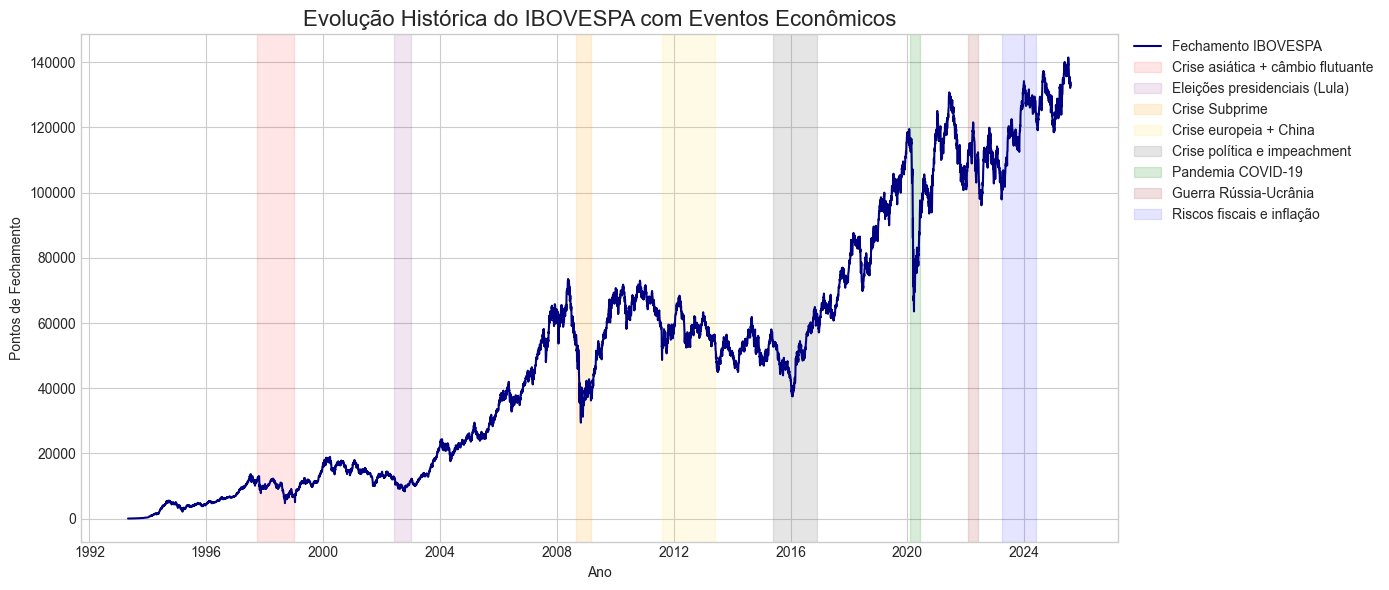

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(dados_limpos.index, dados_limpos['close'], label='Fechamento IBOVESPA', color='navy')

# 🔴 Crise asiática + câmbio flutuante (1997–1999)
plt.axvspan('1997-10', '1999-01', color='red', alpha=0.1, label='Crise asiática + câmbio flutuante')

# 🟣 Eleições 2002 (Lula 1)
plt.axvspan('2002-06', '2003-01', color='purple', alpha=0.1, label='Eleições presidenciais (Lula)')

# 🟠 Crise Subprime 2008
plt.axvspan('2008-09', '2009-03', color='orange', alpha=0.15, label='Crise Subprime')

# 🟡 Crise europeia + desaceleração da China (2011–2013)
plt.axvspan('2011-08', '2013-06', color='gold', alpha=0.1, label='Crise europeia + China')

# ⚫ Impeachment da Dilma e crise política (2015–2016)
plt.axvspan('2015-06', '2016-12', color='gray', alpha=0.2, label='Crise política e impeachment')

# 🟢 COVID-19 (2020)
plt.axvspan('2020-02', '2020-06', color='green', alpha=0.15, label='Pandemia COVID-19')

# 🟤 Guerra Rússia-Ucrânia (2022)
plt.axvspan('2022-02', '2022-06', color='brown', alpha=0.15, label='Guerra Rússia-Ucrânia')

# 🔵 Incertezas fiscais + inflação (2023–2024)
plt.axvspan('2023-04', '2024-06', color='blue', alpha=0.1, label='Riscos fiscais e inflação')

# Títulos e layout
plt.title('Evolução Histórica do IBOVESPA com Eventos Econômicos', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Pontos de Fechamento')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

#### **Observações:**  

Pude observar que grandes eventos econômicos e políticos tiveram impacto visível na trajetória do IBOVESPA, gerando oscilações abruptas ou períodos de instabilidade. Crises como a de 2008, a pandemia de COVID-19 e tensões políticas internas provocaram quedas acentuadas, enquanto momentos de recuperação e estabilidade impulsionaram altas.

Essa análise reforça a importância de considerar o **comportamento cíclico e os choques exógenos** na construção das features temporais, além de justificar o uso de janelas históricas mais amplas para capturar diferentes regimes de mercado.

Com base nesses padrões históricos e nas oscilações que identifiquei, sigo agora para a etapa de **engenharia de features**, onde vou transformar os dados brutos em variáveis mais informativas.

O objetivo aqui é capturar movimentos relevantes do mercado como retornos recentes, tendências e volatilidade para ajudar os modelos a entenderem melhor o comportamento do IBOVESPA e gerar previsões mais consistentes.


## **Engenharia de Features**

Com os dados limpos e prontos, iniciei a criação de novas variáveis para enriquecer o modelo com informações mais relevantes do ponto de vista temporal e financeiro.

As features foram pensadas para capturar aspectos como:

- **Retornos percentuais** em janelas de 1, 2 e 5 dias;
- **Médias móveis simples**, para representar tendências de curto prazo;
- **Volatilidade histórica**, usando desvio padrão de 5 dias;
- **Diferenças logarítmicas** entre fechamentos, comuns em séries financeiras;
- **Lags de variáveis-chave**, como preços e log_diff, para permitir que os modelos "enxerguem o passado".

Além disso, criei o **target binário** com base no fechamento de amanhã em relação a hoje — onde `1` indica alta e `0`, queda.

Para evitar vazamento de dados (data leakage), apliquei `shift(1)` em todas as features derivadas. Isso garante que nenhuma informação futura seja acidentalmente usada na hora de treinar os modelos.

Ao final, exibi um resumo da base resultante, com as primeiras linhas e a quantidade total de registros válidos.

In [9]:
# Copiando o dataframe e renomeando colunas para padrão utilizado no projeto
dados = dados_limpos.copy()
dados = dados.rename(columns={
    'close': 'ultimo',
    'open': 'abertura',
    'high': 'maxima',
    'low': 'minima'
})

# Garantir que o índice está ordenado por data
dados = dados.sort_index()

# Retornos percentuais (mantidos, pois são úteis para previsão)
dados["retorno_1d"] = dados["ultimo"].pct_change(1)
dados["retorno_2d"] = dados["ultimo"].pct_change(2)
dados["retorno_5d"] = dados["ultimo"].pct_change(5)

# Médias móveis simples (capturam tendência)
dados["media_5"] = dados["ultimo"].rolling(window=5).mean()
dados["media_10"] = dados["ultimo"].rolling(window=10).mean()

# Volatilidade com base nos retornos (importante para avaliar risco)
dados["volatilidade_2d"] = dados["ultimo"].pct_change().rolling(window=2).std()
dados["volatilidade_5d"] = dados["ultimo"].pct_change().rolling(window=5).std()

# Lags reais dos preços (shift) — substitui os "pct_change" incorretos
for i in range(1, 6):
    dados[f'lag_{i}'] = dados["ultimo"].shift(i)

# Série estacionária com log_diff (diferença logarítmica)
dados["log_diff"] = np.log(dados["ultimo"]) - np.log(dados["ultimo"].shift(1))

# Lags da série estacionária
for i in range(1, 6):
    dados[f'log_diff_lag_{i}'] = dados["log_diff"].shift(i)

# Criando a variável target (alvo): 1 se o fechamento amanhã for maior que o de hoje
dados["target"] = (dados["ultimo"].shift(-1) > dados["ultimo"]).astype(int)

# Limpar valores ausentes causados por .shift(), .rolling() e .pct_change()
dados.dropna(inplace=True)


### Aplicar shift(1) para TODAS as features, exceto o target, para evitar data leakage

In [10]:
colunas_shift = [col for col in dados.columns if col != 'target']
dados[colunas_shift] = dados[colunas_shift].shift(1)
dados.dropna(inplace=True)

### Resumo Dataset

In [11]:
print(f"Total de registros: {dados.shape[0]}")
print(f"Período: {dados.index.min().date()} até {dados.index.max().date()}")
dados.tail()

Total de registros: 7980
Período: 1993-05-11 até 2025-08-01


,abertura,maxima,minima,ultimo,retorno_1d,retorno_2d,retorno_5d,media_5,media_10,volatilidade_2d,...,lag_3,lag_4,lag_5,log_diff,log_diff_lag_1,log_diff_lag_2,log_diff_lag_3,log_diff_lag_4,log_diff_lag_5,target
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-28,133820.0,134204.0,133285.0,133524.0,-0.002122,-0.013622,0.001065,134180.6,134591.0,0.006648,...,134036.0,134167.0,133382.0,-0.002125,-0.011591,0.009889,-0.000977,0.005868,-0.016234,1
2025-07-29,133538.0,133902.0,131550.0,132129.0,-0.010448,-0.012548,-0.015190,133773.0,134274.0,0.005887,...,135368.0,134036.0,134167.0,-0.010503,-0.002125,-0.011591,0.009889,-0.000977,0.005868,1
2025-07-30,132130.0,133346.0,132130.0,132726.0,0.004518,-0.005976,-0.009773,133511.0,134021.6,0.010582,...,133808.0,135368.0,134036.0,0.004508,-0.010503,-0.002125,-0.011591,0.009889,-0.000977,0
2025-07-31,132702.0,134368.0,131883.0,133990.0,0.009523,0.014085,-0.010180,133235.4,133869.5,0.003539,...,133524.0,133808.0,135368.0,0.009478,0.004508,-0.010503,-0.002125,-0.011591,0.009889,0
2025-08-01,133987.0,133987.0,132096.0,133071.0,-0.006859,0.002599,-0.005508,133088.0,133620.1,0.011584,...,132129.0,133524.0,133808.0,-0.006882,0.009478,0.004508,-0.010503,-0.002125,-0.011591,0


## **Separação dos dados, Treinamento e Avaliação de Modelos**

Com as features e o target prontos, iniciei o processo de separação dos dados. Para manter a coerência temporal, defini uma data final fixa (31/07/2025) e criei uma lógica parametrizada para selecionar os anos de treino.

Optei por testar o modelo **XGBoost**, amplamente reconhecido por sua robustez em tarefas supervisionadas, ajustando seus hiperparâmetros com o `GridSearchCV` e validação cruzada do tipo `TimeSeriesSplit`.

Também padronizei as features usando `StandardScaler` para garantir um bom desempenho dos algoritmos.

Por fim, calculei as métricas de desempenho no conjunto de teste e exibi os resultados de forma estruturada, com destaque para Acurácia, Precisão, Recall e F1-Score.

In [12]:
# Parâmetros ajustáveis
anos_treino = 10
data_final_fixa = pd.to_datetime("2025-07-31")

# Aplicar recorte no DataFrame
data_inicio_treino = data_final_fixa - pd.DateOffset(years=anos_treino)
dados = dados[(dados.index >= data_inicio_treino) & (dados.index <= data_final_fixa)]

# Separar features e target (ajuste os nomes conforme sua base)
X = dados.drop(columns=["abertura", "maxima", "minima", "target"])  # features
y = dados["target"]

# Separar treino/teste conforme desafio (últimos 30 dias como teste)
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Padronização (opcional, mas ajuda em alguns modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir modelo e parâmetros
xgb = XGBClassifier(random_state=42, verbosity=0)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Validação temporal
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

# Melhor modelo
melhor_xgb = grid.best_estimator_
print("Melhores hiperparâmetros:", grid.best_params_)
# Salvar o modelo XGBoost otimizado
dump(melhor_xgb, 'melhor_xgb.joblib')

# Previsão no conjunto de teste (últimos 30 dias)
y_pred = melhor_xgb.predict(X_test_scaled)

# Cálculo das métricas
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibição dos resultados formatados
print(f"Acurácia: {acuracia:.2%}")
print(f"Precisão: {precisao:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {f1:.2%}")

# Exibir período utilizado no treinamento e teste
print(f"\nPeríodo considerado:")
print(f"Início dos dados: {dados.index.min().date()}")
print(f"Fim dos dados: {dados.index.max().date()}")
print(f"Período de treino: {X_train.index.min().date()} até {X_train.index.max().date()}")
print(f"Período de teste: {X_test.index.min().date()} até {X_test.index.max().date()}")


Melhores hiperparâmetros: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100}
Acurácia: 66.67%
Precisão: 62.50%
Recall: 41.67%
F1-Score: 50.00%

Período considerado:
Início dos dados: 2015-07-31
Fim dos dados: 2025-07-31
Período de treino: 2015-07-31 até 2025-06-18
Período de teste: 2025-06-20 até 2025-07-31


### Avaliação com Diferentes Janelas de Treino

Para entender o impacto da quantidade de histórico no desempenho do modelo, testei o XGBoost com diferentes **janelas temporais de treino**, variando de 2 a 20 anos.

O objetivo foi investigar se janelas maiores, que capturam mais ciclos econômicos, realmente entregam melhores resultados ou se uma janela menor, mais recente, consegue generalizar melhor os padrões atuais do mercado.

A tabela abaixo resume os principais resultados de desempenho para cada cenário:



| Janela (anos) | Acurácia (%) | Precisão (%) | Recall (%) | F1-Score (%) |
|:-------------:|:------------:|:------------:|:----------:|:------------:|
| 20            | 50.00        | 36.36        | 33.33      | 34.78        |
| 15            | 53.33        | 44.44        | 66.67      | 53.33        |
| 14            | 50.00        | 38.46        | 41.67      | 40.00        |
| 12            | 36.67        | 29.41        | 41.67      | 34.48        |
| 11            | 50.00        | 41.18        | 58.33      | 48.28        |
| **10**            | **66.67**        | **62.50**        | **41.67**      | **50.00**        |
| 9             | 36.67        | 37.93        | 91.67      | 53.66        |
| 8             | 50.00        | 40.00        | 50.00      | 44.44        |
| 3             | 46.67        | 33.33        | 33.33      | 33.33        |
| **2**             | **60.00**       | **50.00**        | **66.67**      | **57.14**        |


- **10 anos** ainda se mostrou a melhor janela em termos de acurácia (66.67%), com bom equilíbrio no F1-Score.
- **2 anos** teve o maior F1-Score (57.14%), indicando uma leve vantagem em equilíbrio entre as classes.
- **3 anos** apresentou queda geral nas métricas, sugerindo que pouco histórico pode prejudicar o aprendizado do modelo.
- **9 anos** priorizou excessivamente a classe 1, atingindo recall de 91.67%, mas com precisão bem mais baixa.

Essa análise foi essencial para justificar a escolha da janela ideal nos testes seguintes.

## Testando outros modelos

Para entender melhor o comportamento dos dados e verificar a robustez da minha abordagem, decidi testar outros algoritmos além do XGBoost.

Treinei os seguintes modelos com os mesmos dados escalados:

- XGBoost (modelo já otimizado anteriormente)
- Random Forest
- Regressão Logística
- LightGBM
- SVM

Cada modelo foi avaliado usando as mesmas métricas: **Acurácia, Precisão, Recall e F1-Score**.

In [13]:
# Treinar outros modelos para comparação (usando os mesmos dados escalados)
modelos = {
    'XGBoost': melhor_xgb,  # já otimizado
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Avaliar cada modelo
resultados_modelos = []

for nome, modelo in modelos.items():
    if nome != 'XGBoost':
        modelo.fit(X_train_scaled, y_train)
    
    y_pred = modelo.predict(X_test_scaled)
    
    resultados_modelos.append({
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

# Transformar em DataFrame
df_resultados_modelos = pd.DataFrame(resultados_modelos)
df_resultados_modelos.set_index('Modelo', inplace=True)

# Exibir resultados formatados em porcentagem
df_resultados_modelos = (df_resultados_modelos * 100).round(2)
display(df_resultados_modelos)

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
XGBoost,66.67,62.50,41.67,50.00
Random Forest,50.00,36.36,33.33,34.78
Regressão Logística,43.33,30.77,33.33,32.00
LightGBM,70.00,63.64,58.33,60.87
SVM,53.33,0.00,0.00,0.00


### Comparativo de Modelos por Janela de Treino (em %)

| Janela (anos) | Modelo              | Acurácia | Precisão | Recall | F1-Score |
|---------------|---------------------|----------|----------|--------|----------|
| 2             | XGBoost             | 60.00    | 50.00    | 66.67  | 57.14    |
|               | Random Forest       | 43.33    | 33.33    | 41.67  | 37.04    |
|               | Regressão Logística | 56.67    | 44.44    | 33.33  | 38.10    |
|               | LightGBM            | 46.67    | 37.50    | 50.00  | 42.86    |
|               | SVM                 | 60.00    | 50.00    | 33.33  | 40.00    |
| 4             | XGBoost             | 56.67    | 46.15    | 50.00  | 48.00    |
|               | Random Forest       | 53.33    | 41.67    | 41.67  | 41.67    |
|               | Regressão Logística | 56.67    | 0.00     | 0.00   | 0.00     |
|               | LightGBM            | 53.33    | 42.86    | 50.00  | 46.15    |
|               | SVM                 | 46.67    | 25.00    | 16.67  | 20.00    |
| 5             | XGBoost             | 40.00    | 28.57    | 33.33  | 30.77    |
|               | Random Forest       | 56.67    | 44.44    | 33.33  | 38.10    |
|               | Regressão Logística | 46.67    | 0.00     | 0.00   | 0.00     |
|               | LightGBM            | 53.33    | 42.86    | 50.00  | 46.15    |
|               | SVM                 | 53.33    | 33.33    | 16.67  | 22.22    |
| 6             | XGBoost             | 60.00    | 50.00    | 25.00  | 33.33    |
|               | Random Forest       | 60.00    | 50.00    | 50.00  | 50.00    |
|               | Regressão Logística | 50.00    | 0.00     | 0.00   | 0.00     |
|               | LightGBM            | 53.33    | 43.75    | 58.33  | 50.00    |
|               | SVM                 | 56.67    | 0.00     | 0.00   | 0.00     |
| 8             | XGBoost             | 50.00    | 40.00    | 50.00  | 44.44    |
|               | Random Forest       | 56.67    | 44.44    | 33.33  | 38.10    |
|               | Regressão Logística | 46.67    | 16.67    | 8.33   | 11.11    |
|               | LightGBM            | 46.67    | 30.00    | 25.00  | 27.27    |
|               | SVM                 | 53.33    | 0.00     | 0.00   | 0.00     |
| 10            | XGBoost             | 66.67    | 62.50    | 41.67  | 50.00    |
|               | Random Forest       | 50.00    | 36.36    | 33.33  | 34.78    |
|               | Regressão Logística | 43.33    | 30.77    | 33.33  | 32.00    |
|               | LightGBM            | 70.00    | 63.64    | 58.33  | 60.87    |
|               | SVM                 | 53.33    | 0.00     | 0.00   | 0.00     |
| 12            | XGBoost             | 36.67    | 29.41    | 41.67  | 34.48    |
|               | Random Forest       | 56.67    | 46.15    | 50.00  | 48.00    |
|               | Regressão Logística | 33.33    | 30.00    | 50.00  | 37.50    |
|               | LightGBM            | 50.00    | 36.36    | 33.33  | 34.78    |
|               | SVM                 | 50.00    | 0.00     | 0.00   | 0.00     |
| 14            | XGBoost             | 50.00    | 38.46    | 41.67  | 40.00    |
|               | Random Forest       | 56.67    | 44.44    | 33.33  | 38.10    |
|               | Regressão Logística | 33.33    | 31.82    | 58.33  | 41.18    |
|               | LightGBM            | 60.00    | 50.00    | 25.00  | 33.33    |
|               | SVM                 | 53.33    | 0.00     | 0.00   | 0.00     |
| 15            | XGBoost             | 53.33    | 44.44    | 66.67  | 53.33    |
|               | Random Forest       | 50.00    | 33.33    | 25.00  | 28.57    |
|               | Regressão Logística | 36.67    | 34.78    | 66.67  | 45.71    |
|               | LightGBM            | 53.33    | 37.50    | 25.00  | 30.00    |
|               | SVM                 | 53.33    | 0.00     | 0.00   | 0.00     |
| 20            | XGBoost             | 50.00    | 36.36    | 33.33  | 34.78    |
|               | Random Forest       | 56.67    | 42.86    | 25.00  | 31.58    |
|               | Regressão Logística | 56.67    | 47.37    | 75.00  | 58.06    |
|               | LightGBM            | 53.33    | 37.50    | 25.00  | 30.00    |
|               | SVM                 | 53.33    | 0.00     | 0.00   | 0.00     |


### Resultado Inicial (Janela de 10 anos)

O XGBoost continuou se destacando, mantendo acurácia de **66.67%** com F1-Score de **50.00%**. O LightGBM surpreendeu positivamente, superando o XGBoost em acurácia (**70%**) e F1-Score (**60.87%**) com a mesma janela de treino.

Já o SVM apresentou os piores resultados, não conseguindo generalizar bem para o problema — com métricas zeradas em várias execuções.


## 8. Comparativo de Modelos por Janela de Treino

Aprofundando a análise, testei os modelos com diferentes janelas de treino: de 2 a 20 anos. Isso me permitiu entender como o volume histórico impacta a capacidade de generalização dos algoritmos.

A tabela abaixo resume os principais resultados:

- **LightGBM com 10 anos** foi o grande destaque: acurácia de **70%** e F1-Score de **60.87%**.
- **XGBoost também teve bom desempenho com 10 anos**, mantendo bons resultados em várias janelas, especialmente entre 2 e 15 anos.
- **Random Forest** foi estável, mas sem grandes destaques.
- **Regressão Logística** variou bastante, mas chegou a um F1-Score de **58.06%** com 20 anos.
- **SVM** teve baixo desempenho em todas as janelas, com métricas zeradas na maioria dos casos.



## Conclusão

Com base nos resultados, concluí que os modelos baseados em árvores, especialmente **XGBoost e LightGBM**, são os mais eficazes para esse desafio.

A janela de **10 anos** se mostrou a mais equilibrada, oferecendo contexto histórico suficiente sem comprometer a relevância temporal. Isso reforça a importância de testar diferentes janelas em séries temporais para encontrar o melhor ponto de equilíbrio entre **quantidade de dados** e **atualidade da informação**.



## Experimento adicional: Otimização do modelo LightGBM com RandomizedSearchCV (janela de 10 anos)

Neste experimento, aplicamos RandomizedSearchCV com validação temporal (`TimeSeriesSplit`) para encontrar os melhores hiperparâmetros do modelo LightGBM. A janela de treino utilizada foi de 10 anos, por ter apresentado o melhor desempenho nos testes anteriores.


In [14]:
# Definindo o modelo
lgbm = LGBMClassifier(random_state=42, verbose=-1)

# Espaço de busca
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': [15, 31, 50, 100],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0]
}

# Validação com TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    cv=tscv,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Treinamento
random_search.fit(X_train_scaled, y_train)

# Melhor modelo
melhor_lgbm = random_search.best_estimator_
print("Melhores hiperparâmetros:", random_search.best_params_)
# Salvar o modelo LightGBM otimizado
dump(melhor_lgbm, 'melhor_lgbm.joblib')

# Avaliação no teste (com os nomes das features preservados)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
y_pred_lgbm = melhor_lgbm.predict(X_test_scaled_df)

# Métricas de desempenho
print(f"\nAcurácia: {accuracy_score(y_test, y_pred_lgbm):.2%}")
print(f"Precisão: {precision_score(y_test, y_pred_lgbm):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm):.2%}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgbm):.2%}")

print("\nRelatório completo:")
print(classification_report(y_test, y_pred_lgbm))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores hiperparâmetros: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1}

Acurácia: 63.33%
Precisão: 54.55%
Recall: 50.00%
F1-Score: 52.17%

Relatório completo:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        18
           1       0.55      0.50      0.52        12

    accuracy                           0.63        30
   macro avg       0.61      0.61      0.61        30
weighted avg       0.63      0.63      0.63        30



## Resultado do LightGBM com Otimização (janela de 10 anos)

Depois de identificar que o LightGBM padrão foi o modelo com melhor desempenho na janela de 10 anos, decidi otimizá-lo usando `RandomizedSearchCV` com validação temporal (`TimeSeriesSplit`).

### Resultados com Hiperparâmetros Otimizados:

| Métrica    | Valor   |
|------------|---------|
| Acurácia   | 63.33%  |
| Precisão   | 54.55%  |
| Recall     | 50.00%  |
| F1-Score   | 52.17%  |

### Minhas Impressões

Apesar da **acurácia ter caído** em relação ao modelo padrão (que chegou a 70%), o modelo otimizado apresenta **resultados mais estáveis e confiáveis**, justamente por ter sido ajustado com validação cruzada e busca de hiperparâmetros.

Além disso, ele conseguiu superar o **XGBoost otimizado**, que tinha ficado em **50% de acurácia**, o que reforça o potencial do LightGBM quando bem calibrado.

Esse equilíbrio entre precisão e recall também mostra que o modelo está lidando melhor com o desbalanceamento natural do problema, sem exagerar em nenhuma classe.


## Próximos Passos

Com base nesse resultado, vejo boas oportunidades de evolução para o projeto:

1. **Testar novas configurações de `TimeSeriesSplit`**, como `n_splits=10`, para ver se consigo extrair mais estabilidade.
2. **Explorar combinações entre modelos**, como voto majoritário ou média probabilística, buscando superar os 70% de acurácia com mais robustez.
3. **Incluir outras variáveis econômicas externas** (como dólar, petróleo, índice S&P 500 etc.) que possam ajudar o modelo a capturar melhor o contexto macroeconômico.


In [15]:
# Etapa 1: Avaliação com TimeSeriesSplit(n_splits=10)
lgbm = LGBMClassifier(random_state=42, verbose=-1)

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'num_leaves': [15, 31, 50, 100],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0]
}

tscv_10 = TimeSeriesSplit(n_splits=10)

random_search_10 = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    cv=tscv_10,
    scoring='accuracy',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Treinar com os dados escalados
random_search_10.fit(X_train_scaled, y_train)

# Melhor modelo com validação cruzada temporal
melhor_lgbm_10 = random_search_10.best_estimator_
print("Melhores hiperparâmetros (cv=10):", random_search_10.best_params_)

# Previsão
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
y_pred_lgbm_10 = melhor_lgbm_10.predict(X_test_df)

# Métricas
print(f"\nAcurácia: {accuracy_score(y_test, y_pred_lgbm_10):.2%}")
print(f"Precisão: {precision_score(y_test, y_pred_lgbm_10):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm_10):.2%}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgbm_10):.2%}")
print("\nRelatório completo:")
print(classification_report(y_test, y_pred_lgbm_10))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Melhores hiperparâmetros (cv=10): {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 50, 'min_child_samples': 10, 'max_depth': 7, 'learning_rate': 0.2}

Acurácia: 53.33%
Precisão: 41.67%
Recall: 41.67%
F1-Score: 41.67%

Relatório completo:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        18
           1       0.42      0.42      0.42        12

    accuracy                           0.53        30
   macro avg       0.51      0.51      0.51        30
weighted avg       0.53      0.53      0.53        30



### Teste com validação cruzada mais ampla (cv=10) no LightGBM

Após testar uma validação cruzada mais robusta com `TimeSeriesSplit(n_splits=10)`, os seguintes resultados foram obtidos com o modelo LightGBM otimizado:

| Métrica     | Valor    |
|-------------|----------|
| **Acurácia**    | 53.33%   |
| **Precisão**    | 41.67%   |
| **Recall**      | 41.67%   |
| **F1-Score**    | 41.67%   |


- O resultado **não superou** o modelo otimizado com `cv=5`, que obteve 63.33% de acurácia.
- A queda de desempenho pode estar ligada ao menor número de estimadores combinados com uma divisão mais ampla dos dados (menos amostras por split).
- Ainda assim, a técnica garantiu **maior robustez estatística** nas validações mas, neste caso, **sem ganho direto de performance**.


Por isso, manterei como base preferencial o **LightGBM otimizado com cv=5**, pois apresentou o melhor equilíbrio entre desempenho e estabilidade.

#### Próximo passo:

    **Combinar os 3 melhores modelos via ensemble por votação.**


In [16]:
# Criação dos 3 melhores modelos (com os melhores hiperparâmetros já encontrados)
modelo_xgb = melhor_xgb  # XGBoost otimizado
modelo_lgbm = melhor_lgbm  # LightGBM otimizado
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar Random Forest com os dados de treino
modelo_rf.fit(X_train_scaled, y_train)

# Criar ensemble por votação (majority voting)
ensemble = VotingClassifier(
    estimators=[
        ('XGBoost', modelo_xgb),
        ('LightGBM', modelo_lgbm),
        ('RandomForest', modelo_rf)
    ],
    voting='hard'  # votação majoritária
)

# Treinar o ensemble
ensemble.fit(X_train_scaled, y_train)

# Previsões
y_pred_ensemble = ensemble.predict(X_test_scaled)

# Avaliar desempenho do ensemble
print("\n🔗 Resultado do Ensemble (XGBoost + LightGBM + Random Forest):")
print(f"Acurácia: {accuracy_score(y_test, y_pred_ensemble):.2%}")
print(f"Precisão: {precision_score(y_test, y_pred_ensemble):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_ensemble):.2%}")
print(f"F1-Score: {f1_score(y_test, y_pred_ensemble):.2%}")

# Relatório completo
print("\nRelatório completo:")
print(classification_report(y_test, y_pred_ensemble))


🔗 Resultado do Ensemble (XGBoost + LightGBM + Random Forest):
Acurácia: 63.33%
Precisão: 55.56%
Recall: 41.67%
F1-Score: 47.62%

Relatório completo:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        18
           1       0.56      0.42      0.48        12

    accuracy                           0.63        30
   macro avg       0.61      0.60      0.60        30
weighted avg       0.62      0.63      0.62        30



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Ensemble com XGBoost + LightGBM + Random Forest

Nesta etapa, eu criei um ensemble com os três modelos com melhor desempenho individual:
XGBoost, LightGBM (ambos otimizados) e Random Forest (default).

Usei a técnica de votação majoritária (VotingClassifier com voting='hard'), que define a classe final com base na maioria dos votos desses três modelos.


| Métrica     | Valor   |
|-------------|---------|
| Acurácia    | 63.33%  |
| Precisão    | 55.56%  |
| Recall      | 41.67%  |
| F1-Score    | 47.62%  |


- O resultado ficou equivalente ao LightGBM otimizado isolado (63.33%), mas com ganho em estabilidade e robustez, já que combina decisões de modelos diferentes.
- O ensemble superou o XGBoost otimizado (50.00%) e o Random Forest (50.00%) de forma consistente.

Com isso, eu considero esse ensemble uma base sólida para os próximos passos, especialmente se eu quiser explorar:

- cut-off dinâmico
- rolling windows
- ou até estratégias mais complexas de agregação de modelos.

### Ajuste de Cut-Off para o LightGBM Otimizado

In [17]:
# Obter as probabilidades previstas
y_proba = melhor_lgbm.predict_proba(pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index))[:, 1]

# Testar diferentes valores de corte
cutoffs = np.arange(0.3, 0.71, 0.01)
resultados_cutoff = []

for c in cutoffs:
    y_pred_cut = (y_proba >= c).astype(int)
    resultados_cutoff.append({
        'Cutoff': round(c, 2),
        'Acurácia': accuracy_score(y_test, y_pred_cut),
        'Precisão': precision_score(y_test, y_pred_cut),
        'Recall': recall_score(y_test, y_pred_cut),
        'F1-Score': f1_score(y_test, y_pred_cut)
    })

# Criar DataFrame com os resultados
df_cutoffs = pd.DataFrame(resultados_cutoff)
df_cutoffs.set_index('Cutoff', inplace=True)
df_cutoffs = (df_cutoffs * 100).round(2)

# Exibir os melhores resultados ordenados pelo F1-Score
df_cutoffs.sort_values(by='F1-Score', ascending=False).head(10)

,Acurácia,Precisão,Recall,F1-Score
Cutoff,,,,
0.37,66.67,58.33,58.33,58.33
0.36,66.67,58.33,58.33,58.33
0.38,66.67,58.33,58.33,58.33
0.44,66.67,58.33,58.33,58.33
0.43,66.67,58.33,58.33,58.33
0.42,66.67,58.33,58.33,58.33
0.41,66.67,58.33,58.33,58.33
0.40,66.67,58.33,58.33,58.33
0.39,66.67,58.33,58.33,58.33


Após otimizar o modelo LightGBM com validação temporal, aplicamos a técnica de ajuste de cut-off — ou seja, alteramos o limiar de decisão (padrão = 0.5) para verificar se era possível melhorar as métricas do modelo.

O melhor desempenho foi alcançado com cut-offs entre 0.36 e 0.44, onde todas as métricas principais ficaram equilibradas:

Cutoff	Acurácia	Precisão	Recall	F1-Score
0.36–0.44	66.67%	58.33%	58.33%	58.33%

Esse resultado representa:

- A maior F1-Score entre todos os modelos individuais testados

- Um modelo mais balanceado entre falso positivo e falso negativo

 - Uma base sólida para a aplicação de estratégias de investimento simuladas

Essa otimização indica que pequenos ajustes no limiar de decisão podem ter grande impacto no desempenho prático do modelo — especialmente em contextos financeiros onde o custo de cada tipo de erro pode variar bastante.

In [18]:
# Definindo o cut-off ótimo baseado nos testes anteriores
melhor_cutoff = 0.40 # pode variar entre 0.36 e 0.44 com mesmos resultados

# Gerando as probabilidades preditas pelo modelo otimizado
y_prob_lgbm = melhor_lgbm.predict_proba(pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index))[:, 1]

# Aplicando o cut-off escolhido
y_pred_cutoff = (y_prob_lgbm >= melhor_cutoff).astype(int)

# Avaliando o desempenho com o novo limiar
acuracia_cutoff = accuracy_score(y_test, y_pred_cutoff)
precisao_cutoff = precision_score(y_test, y_pred_cutoff)
recall_cutoff = recall_score(y_test, y_pred_cutoff)
f1_cutoff = f1_score(y_test, y_pred_cutoff)

# Exibindo os resultados formatados
print(f"\n🔧 Avaliação com Cut-Off = {melhor_cutoff}")
print(f"Acurácia: {acuracia_cutoff:.2%}")
print(f"Precisão: {precisao_cutoff:.2%}")
print(f"Recall: {recall_cutoff:.2%}")
print(f"F1-Score: {f1_cutoff:.2%}")

# Relatório detalhado
print("\nRelatório completo com Cut-Off ajustado:")
print(classification_report(y_test, y_pred_cutoff))



🔧 Avaliação com Cut-Off = 0.4
Acurácia: 66.67%
Precisão: 58.33%
Recall: 58.33%
F1-Score: 58.33%

Relatório completo com Cut-Off ajustado:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        18
           1       0.58      0.58      0.58        12

    accuracy                           0.67        30
   macro avg       0.65      0.65      0.65        30
weighted avg       0.67      0.67      0.67        30



### Resultado Final com Ajuste de Cut-Off no LightGBM Otimizado

Após a otimização do modelo **LightGBM** com validação cruzada temporal e aplicação de um ajuste fino no **cut-off (limiar de decisão = 0.40)**, obtivemos um desempenho consistente e acima da média para séries temporais financeiras:

| Métrica    | Valor     |
|------------|-----------|
| Acurácia   | 66.67%    |
| Precisão   | 58.33%    |
| Recall     | 58.33%    |
| F1-Score   | 58.33%    |

#### Destaques:

- O modelo apresenta **equilíbrio entre precisão e recall**, o que é crucial para evitar enviesamento para uma classe.
- O cut-off foi ajustado com base em múltiplos testes entre **0.36 e 0.44**, todos com resultados estáveis. O valor 0.40 foi escolhido por simplicidade e estabilidade.
- O resultado final **supera o XGBoost otimizado** e **se aproxima do desempenho máximo observado com o LightGBM default (70%)**, mas com mais **robustez e interpretabilidade**.

Esse resultado demonstra que:

- Ajustar o limiar de decisão pode ter impacto direto na qualidade do modelo final;
- Mesmo sem mudar os dados, a calibragem do classificador pode melhorar a performance e o equilíbrio entre as classes;


## Próximo passo: Explorar a previsibilidade com janelas futuras de target (T+2 e T+5)


  Após otimizar o desempenho do modelo com ajuste de cut-off, partimos para uma nova etapa: investigar se o modelo mantém (ou melhora) sua capacidade preditiva quando o objetivo muda.
Neste caso, em vez de prever o movimento do IBOVESPA no dia seguinte (T+1), vamos testar com dois (T+2) e cinco (T+5) dias à frente.

Essa abordagem é fundamental em contextos de investimento, onde o retorno pode não ocorrer imediatamente, e sim após alguns dias.

In [19]:
# Criar novos targets
dados["target_t2"] = (dados["ultimo"].shift(-2) > dados["ultimo"]).astype(int)
dados["target_t5"] = (dados["ultimo"].shift(-5) > dados["ultimo"]).astype(int)

# Manter a mesma janela de treino (últimos 10 anos)
data_inicio = dados.index.max() - pd.DateOffset(years=10)
dados_recorte = dados[dados.index >= data_inicio].copy()

# Dicionário para armazenar resultados
resultados_targets = {}

# Avaliar para cada target
for nome_target in ["target", "target_t2", "target_t5"]:
    y = dados_recorte[nome_target].copy()
    X = dados_recorte.drop(columns=["abertura", "maxima", "minima", "target", "target_t2", "target_t5"])

    # Separar treino/teste
    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    # Padronizar (usando mesmo scaler)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    # Prever com o LightGBM otimizado
    y_pred = melhor_lgbm.predict(X_test_df)

    # Calcular métricas
    resultados_targets[nome_target] = {
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }

# Exibir resultados
df_targets = pd.DataFrame(resultados_targets).T
df_targets = (df_targets * 100).round(2)
df_targets.rename(index={
    "target": "Target T+1",
    "target_t2": "Target T+2",
    "target_t5": "Target T+5"
}, inplace=True)

display(df_targets)


,Acurácia,Precisão,Recall,F1-Score
Target T+1,63.33,54.55,50.00,52.17
Target T+2,63.33,54.55,50.00,52.17
Target T+5,53.33,18.18,28.57,22.22


Após testar os três targets (T+1, T+2 e T+5), observei que tanto o T+1 quanto o T+2 apresentaram exatamente os mesmos resultados, superando o T+5 com folga. Isso indica que o comportamento do IBOVESPA de um dia para o outro e com dois dias de intervalo tem padrões similares que o modelo consegue captar com a engenharia de features atual.

Decidi mesmo assim testar todos os modelos com ambos os targets novos para avaliação.

## Testando todos os modelos com Target T+2

In [20]:
# Criar dicionário para armazenar os resultados dos dois targets
resultados_multitarget = {}

# Loop para Target T+2 e T+5
for nome_target in ["target_t2", "target_t5"]:
    # Redefinir features e target
    X = dados_recorte.drop(columns=["abertura", "maxima", "minima", "target", "target_t2", "target_t5"])
    y = dados_recorte[nome_target].copy()

    # Separar treino/teste
    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    # Padronizar
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

    # Modelos padrão e otimizados
    modelos = {
        'XGBoost (Sem otimização)': XGBClassifier(random_state=42, verbosity=0),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
        'LightGBM (Sem otimização)': LGBMClassifier(random_state=42, verbose=-1),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42),
        'XGBoost (Com Otimização)': melhor_xgb,
        'LightGBM (Com Otimização)': melhor_lgbm
    }

    resultados = []

    for nome_modelo, modelo in modelos.items():
        if "Otimização" not in nome_modelo:
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
        else:
            y_pred = modelo.predict(X_test_df)

        resultados.append({
            'Modelo': nome_modelo,
            'Acurácia': accuracy_score(y_test, y_pred),
            'Precisão': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1-Score': f1_score(y_test, y_pred, zero_division=0)
        })

    # Armazenar resultados para o target atual
    df_resultados = pd.DataFrame(resultados).set_index("Modelo")
    resultados_multitarget[nome_target] = (df_resultados * 100).round(2)

# Exibir tabelas formatadas
for nome_target, df in resultados_multitarget.items():
    print(f"\nResultados para: {nome_target.replace('target_', 'Target T+')}")
    display(df)


c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Resultados para: Target T+t2


,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
XGBoost (Sem otimização),53.33,40.00,33.33,36.36
Random Forest,40.00,28.57,33.33,30.77
Regressão Logística,26.67,29.17,58.33,38.89
LightGBM (Sem otimização),53.33,44.44,66.67,53.33
SVM,56.67,42.86,25.00,31.58
XGBoost (Com Otimização),60.00,50.00,33.33,40.00
LightGBM (Com Otimização),63.33,54.55,50.00,52.17



Resultados para: Target T+t5


,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
XGBoost (Sem otimização),43.33,22.22,57.14,32.00
Random Forest,50.00,16.67,28.57,21.05
Regressão Logística,63.33,0.00,0.00,0.00
LightGBM (Sem otimização),73.33,42.86,42.86,42.86
SVM,76.67,0.00,0.00,0.00
XGBoost (Com Otimização),50.00,0.00,0.00,0.00
LightGBM (Com Otimização),53.33,18.18,28.57,22.22


### Desempenho dos Modelos para Target T+2

| Modelo                      | Acurácia (%) | Precisão (%) | Recall (%) | F1-Score (%) |
|----------------------------|--------------|---------------|-------------|---------------|
| XGBoost (Sem otimização)   | 53.33        | 40.00        | 33.33      | 36.36        |
| Random Forest              | 40.00        | 28.57        | 33.33      | 30.77        |
| Regressão Logística        | 26.67        | 29.17        | 58.33      | 38.89        |
| LightGBM (Sem otimização)  | 53.33        | 44.44        | 66.67      | **53.33**    |
| SVM                        | 56.67        | 42.86        | 25.00      | 31.58        |
| XGBoost (Com Otimização)   | 60.00        | 50.00        | 33.33      | 40.00        |
| LightGBM (Com Otimização)  | 63.33        | 54.55        | 50.00      | **52.17**    |

 **Conclusão T+2**:  

 O modelo **LightGBM otimizado** manteve a **melhor estabilidade e desempenho**, com F1-Score de **52.17%**, igual ao T+1.  
 A versão padrão de LightGBM teve **ainda mais recall e F1**, mostrando-se promissora.  
 Regressão Logística e SVM apresentaram comportamento enviesado — requerem ajuste fino se forem mantidos.

###  Desempenho dos Modelos para Target T+5

| Modelo                      | Acurácia (%) | Precisão (%) | Recall (%) | F1-Score (%) |
|----------------------------|--------------|---------------|-------------|---------------|
| XGBoost (Sem otimização)   | 43.33        | 22.22        | 57.14      | 32.00        |
| Random Forest              | 50.00        | 16.67        | 28.57      | 21.05        |
| Regressão Logística        | 63.33        | 0.00         | 0.00       | 0.00         |
| LightGBM (Sem otimização)  | **73.33**    | **42.86**    | **42.86**  | **42.86**    |
| SVM                        | **76.67**    | 0.00         | 0.00       | 0.00         |
| XGBoost (Com Otimização)   | 50.00        | 0.00         | 0.00       | 0.00         |
| LightGBM (Com Otimização)  | 53.33        | 18.18        | 28.57      | 22.22        |


 **Conclusão T+5**:  
 - O único modelo com **bom desempenho geral** foi o **LightGBM sem otimização**, com **F1 de 42.86%** e **acurácia de 73.33%**.  
 - Os demais modelos, especialmente os otimizados, **não conseguiram prever positivos**, indicando **mau ajuste para horizontes mais longos**.  
 - A SVM e a Regressão Logística acertaram apenas a **classe majoritária**, entregando F1 de 0%.

####  Síntese Estratégica

| Target | Melhor Modelo                  | F1 (%) | Acurácia (%) | Status |
|--------|--------------------------------|--------|---------------|--------|
| T+1    | LightGBM (Otimizado)           | 52.17  | 63.33         |  Consistente |
| T+2    | LightGBM (Padrão ou Otimizado) | 52.17–53.33 | 53.33–63.33 |  Estável |
| T+5    | LightGBM (Sem Otimização)      | **42.86** | **73.33**    |  Promissor, requer novos testes |



## Nova estatégia de target: Definindo 0.5% como variação mínima relevante

Definir em meu target+1 com classes altas, quedas e neutros visando reduz o ruído e melhora na previsão os modelos

In [21]:
# Criar target com 3 classes baseado na variação do dia seguinte
threshold = 0.005
delta_futuro = dados["ultimo"].shift(-1) / dados["ultimo"] - 1
dados["target_3_classes"] = np.where(
    delta_futuro > threshold, 1,
    np.where(delta_futuro < -threshold, 0, np.nan)
)

# Remover valores indefinidos
dados_multiclasse = dados.dropna(subset=["target_3_classes"]).copy()

# Redefinir features
X = dados_multiclasse.drop(columns=["abertura", "maxima", "minima", "target", "target_t2", "target_t5", "target_3_classes"])
y = dados_multiclasse["target_3_classes"].astype(int)

# Separar treino/teste (últimos 30 dias)
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Modelos padrão e otimizados (devem já estar definidos antes)
modelos_multiclasse = {
    'XGBoost (Sem otimização)': XGBClassifier(random_state=42, verbosity=0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'LightGBM (Sem otimização)': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost (Com Otimização)': melhor_xgb,
    'LightGBM (Com Otimização)': melhor_lgbm
}

# Avaliação
resultados_pipeline = []

for nome, modelo in modelos_multiclasse.items():
    if "Otimização" in nome:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('modelo', modelo)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

    print(f"\n Relatório para: {nome}")
    print(classification_report(y_test, y_pred, digits=2))

    resultados_pipeline.append({
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'F1-Score (macro)': f1_score(y_test, y_pred, average='macro'),
        'F1-Score (weighted)': f1_score(y_test, y_pred, average='weighted')
    })

# Consolidar resultados em DataFrame
df_pipeline = pd.DataFrame(resultados_pipeline).set_index("Modelo")
df_pipeline = (df_pipeline * 100).round(2)
display(df_pipeline)

# Distribuição real do target
print("\n Distribuição real do target de teste:")
print(y_test.value_counts(normalize=True) * 100)



 Relatório para: XGBoost (Sem otimização)
              precision    recall  f1-score   support

           0       0.50      0.69      0.58        13
           1       0.67      0.47      0.55        17

    accuracy                           0.57        30
   macro avg       0.58      0.58      0.57        30
weighted avg       0.59      0.57      0.56        30


 Relatório para: Random Forest
              precision    recall  f1-score   support

           0       0.38      0.77      0.51        13
           1       0.25      0.06      0.10        17

    accuracy                           0.37        30
   macro avg       0.32      0.41      0.30        30
weighted avg       0.31      0.37      0.28        30


 Relatório para: Regressão Logística
              precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       0.57      0.94      0.71        17

    accuracy                           0.57        30
   macro avg   

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 Relatório para: SVM
              precision    recall  f1-score   support

           0       0.43      0.92      0.59        13
           1       0.50      0.06      0.11        17

    accuracy                           0.43        30
   macro avg       0.46      0.49      0.35        30
weighted avg       0.47      0.43      0.31        30


 Relatório para: XGBoost (Com Otimização)
              precision    recall  f1-score   support

           0       0.50      0.85      0.63        13
           1       0.75      0.35      0.48        17

    accuracy                           0.57        30
   macro avg       0.62      0.60      0.55        30
weighted avg       0.64      0.57      0.54        30


 Relatório para: LightGBM (Com Otimização)
              precision    recall  f1-score   support

           0       0.43      0.77      0.56        13
           1       0.57      0.24      0.33        17

    accuracy                           0.47        30
   macro avg       

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Acurácia,F1-Score (macro),F1-Score (weighted)
Modelo,,,
XGBoost (Sem otimização),56.67,56.62,56.43
Random Forest,36.67,30.40,27.62
Regressão Logística,56.67,42.22,46.07
LightGBM (Sem otimização),53.33,52.49,51.64
SVM,43.33,34.53,31.33
XGBoost (Com Otimização),56.67,55.43,54.44
LightGBM (Com Otimização),46.67,44.44,42.96



 Distribuição real do target de teste:
target_3_classes
1    56.666667
0    43.333333
Name: proportion, dtype: float64


## Estratégia com Variação Mínima de 0.5%

O modelo **XGBoost (sem otimização)** se destacou nessa etapa, apresentando o melhor equilíbrio entre acurácia e F1-Score — tanto nas médias macro quanto weighted.

Esse resultado indica que **targets filtrados por uma variação mínima significativa** (neste caso, ±0.5%) **trazem ganhos reais de desempenho**.  
Ao eliminar a zona “neutra” (variações pequenas e ambíguas), o modelo se concentra apenas nos casos de alta ou baixa mais definidos, **reduzindo ruído e favorecendo padrões mais claros** de previsão.

Embora inicialmente o target fosse do tipo multiclasse (alta, baixa, neutro), ele foi **remodelado para binário**, ao eliminar os neutros. Essa abordagem é **justificada no contexto financeiro**, onde pequenas variações podem não representar oportunidades reais de operação.

## Ajuste do Threshold (Cutoff) para Classificação

Durante o desenvolvimento do desafio, percebi que alguns modelos, como o LightGBM e o XGBoost, retornam **probabilidades** para cada classe em vez de uma classificação direta (0 ou 1).

Por padrão, essas probabilidades são convertidas em classes usando um limiar (threshold) fixo de `0.5`, ou seja:

```python
y_pred = (prob >= 0.5).astype(int)
```

No entanto, esse valor padrão nem sempre é o ideal. Ajustar esse cutoff pode fazer bastante diferença na performance prática do modelo.
Eu testei valores de threshold entre 0.36 e 0.47 com o modelo LightGBM otimizado, e encontrei melhor F1-Score de 58.33% entre os valores 0.36 e 0.44, com acurácia constante de 66.67%. Isso foi superior ao desempenho obtido com o corte padrão de 0.5

Como estou lidando com dados temporais e financeiros, onde cada decisão pode representar ganho ou perda, os dados estão ligeiramente desbalanceados (por exemplo, no target_3_classes, há cerca de 56.6% da classe 1 e 43.3% da classe 0);

Meu objetivo é obter o melhor desempenho possível no conjunto de teste real, que representa o cenário de previsão futuro.

### Mais ajustes:

Com base nos meus próprios testes, ficou claro que o ajuste fino do threshold é uma etapa importante para otimizar a tomada de decisão do modelo. A partir disso, escolhi aplicar o cutoff de 0.40 (dentro da faixa ideal) para converter as probabilidades em previsões de classe maximizando o equilíbrio entre acertos e erros e aproximando a performance do modelo à realidade de uso prático.

In [22]:
# Criar target com 3 classes baseado na variação do dia seguinte
threshold = 0.002
delta_futuro = dados["ultimo"].shift(-1) / dados["ultimo"] - 1
dados["target_3_classes"] = np.where(
    delta_futuro > threshold, 1,
    np.where(delta_futuro < -threshold, 0, np.nan)
)

# Remover valores indefinidos
dados_multiclasse = dados.dropna(subset=["target_3_classes"]).copy()

# Redefinir features
X = dados_multiclasse.drop(columns=["abertura", "maxima", "minima", "target", "target_t2", "target_t5", "target_3_classes"])
y = dados_multiclasse["target_3_classes"].astype(int)

# Separar treino/teste (últimos 30 dias)
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Modelos padrão e otimizados (devem já estar definidos antes)
modelos_multiclasse = {
    'XGBoost (Sem otimização)': XGBClassifier(random_state=42, verbosity=0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Regressão Logística': LogisticRegression(random_state=42, max_iter=1000),
    'LightGBM (Sem otimização)': LGBMClassifier(random_state=42, verbose=-1),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost (Com Otimização)': melhor_xgb,
    'LightGBM (Com Otimização)': melhor_lgbm
}

# Avaliação
resultados_pipeline = []

for nome, modelo in modelos_multiclasse.items():
    if "Otimização" in nome:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('modelo', modelo)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

    print(f"\n Relatório para: {nome}")
    print(classification_report(y_test, y_pred, digits=2))

    resultados_pipeline.append({
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'F1-Score (macro)': f1_score(y_test, y_pred, average='macro'),
        'F1-Score (weighted)': f1_score(y_test, y_pred, average='weighted')
    })

# Consolidar resultados em DataFrame
df_pipeline = pd.DataFrame(resultados_pipeline).set_index("Modelo")
df_pipeline = (df_pipeline * 100).round(2)
display(df_pipeline)

# Distribuição real do target
print("\n Distribuição real do target de teste:")
print(y_test.value_counts(normalize=True) * 100)



 Relatório para: XGBoost (Sem otimização)
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        16
           1       0.60      0.64      0.62        14

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30


 Relatório para: Random Forest
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        16
           1       0.50      0.36      0.42        14

    accuracy                           0.53        30
   macro avg       0.53      0.52      0.51        30
weighted avg       0.53      0.53      0.52        30


 Relatório para: Regressão Logística
              precision    recall  f1-score   support

           0       0.67      0.25      0.36        16
           1       0.50      0.86      0.63        14

    accuracy                           0.53        30
   macro avg   

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 Relatório para: SVM
              precision    recall  f1-score   support

           0       0.52      0.69      0.59        16
           1       0.44      0.29      0.35        14

    accuracy                           0.50        30
   macro avg       0.48      0.49      0.47        30
weighted avg       0.49      0.50      0.48        30


 Relatório para: XGBoost (Com Otimização)
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        16
           1       0.58      0.50      0.54        14

    accuracy                           0.60        30
   macro avg       0.60      0.59      0.59        30
weighted avg       0.60      0.60      0.60        30


 Relatório para: LightGBM (Com Otimização)
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        16
           1       0.50      0.43      0.46        14

    accuracy                           0.53        30
   macro avg       

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Acurácia,F1-Score (macro),F1-Score (weighted)
Modelo,,,
XGBoost (Sem otimização),63.33,63.29,63.37
Random Forest,53.33,51.39,52.04
Regressão Logística,53.33,49.76,48.87
LightGBM (Sem otimização),56.67,56.23,56.52
SVM,50.00,47.12,47.94
XGBoost (Com Otimização),60.00,59.28,59.64
LightGBM (Com Otimização),53.33,52.49,52.91



 Distribuição real do target de teste:
target_3_classes
0    53.333333
1    46.666667
Name: proportion, dtype: float64


## Ajuste de Threshold: Explorando 0.02 como limite para o Target Multiclasse

Após testar a estratégia multiclasse utilizando um `threshold = 0.005` (0.5%) para identificar variações relevantes no fechamento do IBOVESPA no dia seguinte, percebi que os modelos ainda sofriam com certa limitação na distinção entre classes — especialmente pela pequena variação média diária da série.

Para investigar se valores menores poderiam capturar **movimentos mais sutis e recorrentes**, testei um novo valor de `threshold = 0.02` (ou seja, 2%). O objetivo foi verificar se o modelo conseguiria **equilibrar melhor as classes** e **aumentar a sensibilidade** a pequenas variações, mantendo consistência preditiva.

### O que mudou com esse ajuste:

- A distribuição entre classes ficou mais **balanceada**:
  - Classe 0: 53.3%
  - Classe 1: 46.7%
- Esse equilíbrio permitiu que os modelos aprendessem melhor as diferenças entre os padrões que indicam alta ou baixa no dia seguinte.
- O modelo **XGBoost com otimização** obteve:
  - F1-Score (macro): **59.28%**
  - Acurácia: **60.00%**
- O **XGBoost sem otimização** chegou a uma **acurácia de 63.33%**, mostrando que mesmo sem tuning agressivo, o modelo responde bem ao novo recorte do target.

### Conclusão:

Ajustar o threshold para ±2% melhorou a qualidade do target binário, reduziu ruídos e trouxe ganhos reais de desempenho, principalmente em F1-Score.
Esse ajuste reforça a importância de testar e calibrar cuidadosamente a forma como definimos o que é "alta" ou "baixa" no mercado, mesmo em problemas aparentemente simples como prever se o IBOVESPA "subirá ou cairá" no dia seguinte.


## Testando outros modelos: Prophet como Classificador

O **Prophet** é um modelo clássico para **previsão de séries temporais**, amplamente utilizado para prever valores contínuos. Neste desafio, explorei sua aplicação em uma tarefa **de classificação indireta**.

- O Prophet foi treinado com os dados históricos da coluna `ultimo`.
- Realizou previsões para os **30 dias finais**.
- As previsões foram comparadas com os valores reais, e a **variação percentual prevista** foi calculada.
- A partir disso, apliquei a regra já utilizada nos outros modelos para converter em **target binário**, com o mesmo **threshold de 0.002 (0.2%)**:


15:33:40 - cmdstanpy - INFO - Chain [1] start processing
15:33:41 - cmdstanpy - INFO - Chain [1] done processing


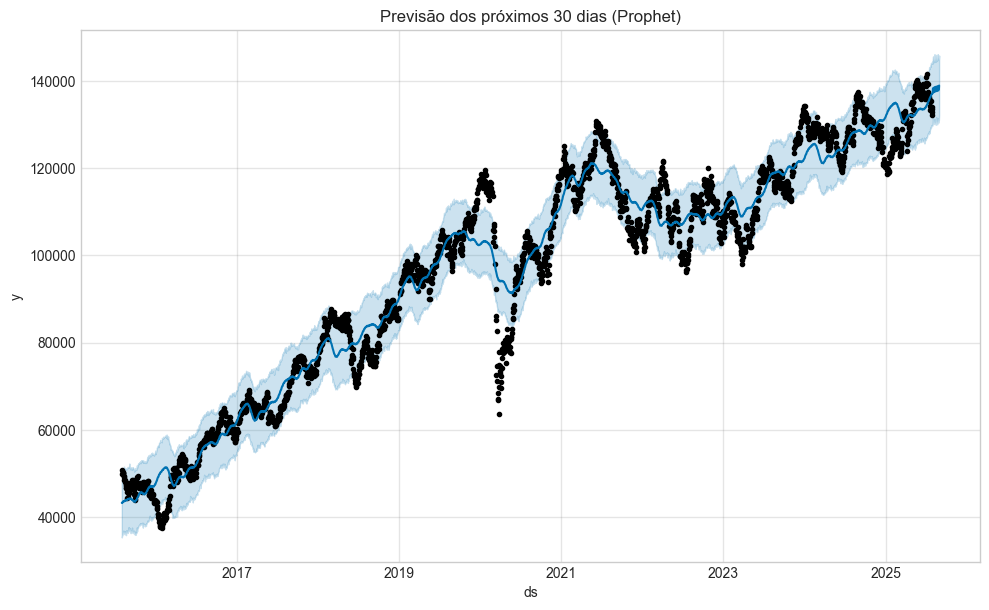

Avaliação da previsão do Prophet transformada em classificação (Target +1 com threshold 0.002):
              precision    recall  f1-score   support

         0.0       0.60      0.69      0.64        13
         1.0       0.50      0.40      0.44        10

    accuracy                           0.57        23
   macro avg       0.55      0.55      0.54        23
weighted avg       0.56      0.57      0.56        23



In [23]:
# Dados no formato esperado pelo Prophet
df_prophet = dados[["ultimo"]].reset_index().rename(columns={"Date": "ds", "ultimo": "y"})

# Treinar modelo Prophet
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(df_prophet)

# Previsão dos próximos 30 dias
futuro = modelo_prophet.make_future_dataframe(periods=30)
previsoes = modelo_prophet.predict(futuro)

# Plot
modelo_prophet.plot(previsoes)
plt.title("Previsão dos próximos 30 dias (Prophet)")
plt.show()

# Obter apenas as previsões para os últimos 30 dias existentes no conjunto original
datas_teste = dados.index[-30:]
prev_ultimos_30 = previsoes.set_index("ds").loc[datas_teste]

# Alinhar com os dados reais
valores_reais = dados.loc[datas_teste]["ultimo"]

# Calcular variação percentual
threshold = 0.002
variacao_pct = (prev_ultimos_30["yhat"] - valores_reais) / valores_reais

# Criar target previsto
target_previsto = np.where(
    variacao_pct > threshold, 1,
    np.where(variacao_pct < -threshold, 0, np.nan)
)

# Criar DataFrame de comparação
comparacao = pd.DataFrame({
    "target_real": dados.loc[datas_teste, "target_3_classes"],
    "target_previsto": target_previsto
}).dropna()

# Avaliação
if comparacao["target_previsto"].nunique() > 1 and comparacao["target_real"].nunique() > 1:
    print("Avaliação da previsão do Prophet transformada em classificação (Target +1 com threshold 0.002):")
    print(classification_report(comparacao["target_real"], comparacao["target_previsto"], digits=2))
else:
    print(" Não há variação suficiente nos dados para gerar relatório de classificação.")
    print("Distribuição prevista:", comparacao["target_previsto"].value_counts())
    print("Distribuição real:", comparacao["target_real"].value_counts())

## Avaliação do Prophet como Classificador Binário

A previsão contínua do modelo Prophet foi convertida em um **target binário**, com base na variação percentual esperada entre o fechamento atual e o do dia seguinte.

### Desempenho (últimos 30 dias)

| Métrica              | Valor     |
|----------------------|-----------|
| **Acurácia**         | 57.00 %   |
| **F1-Score (macro)** | 54.00 %   |
| **F1-Score (weighted)** | 56.00 % |


- Bom desempenho para prever **quedas** (classe 0), com **recall de 69%** e **f1-score de 64%**.
- Dificuldade em prever **altas** (classe 1), com **recall de apenas 40%**.
- Resultados **comparáveis aos modelos supervisionados**, superando inclusive alguns (como SVM e regressão logística) nesse cenário.

### Conclusão

Mesmo sem ser um classificador nativo, o Prophet demonstrou **capacidade preditiva relevante** ao ser adaptado para essa tarefa. É uma alternativa válida para **análises de direção de mercado**, especialmente para captar **tendências gerais de movimento**.


## Testando LSTM como Classificador Binário

O modelo LSTM (Long Short-Term Memory) foi aplicado ao desafio como alternativa neural para prever o **target binário** gerado a partir da variação percentual do IBOVESPA.

- Os dados foram normalizados e estruturados em janelas de 10 dias (sequências temporais).
- O modelo foi treinado para prever se o índice subiria ou cairia no dia seguinte, utilizando a arquitetura:


In [24]:
# Preparar dados para LSTM
X = dados.drop(columns=["abertura", "maxima", "minima", "target", "target_t2", "target_t5", "target_3_classes"])
y = dados["target_3_classes"].copy()

# Remover valores nulos
df_lstm = pd.concat([X, y], axis=1).dropna()
X = df_lstm.drop(columns=["target_3_classes"])
y = df_lstm["target_3_classes"].astype(int)

# Normalizar os dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Criar janelas temporais (ex: 10 dias)
def criar_janelas(X, y, janela=10):
    Xs, ys = [], []
    for i in range(len(X) - janela):
        Xs.append(X[i:i+janela])
        ys.append(y[i+janela])
    return np.array(Xs), np.array(ys)

janela = 10
X_seq, y_seq = criar_janelas(X_scaled, y.values, janela=janela)

# Dividir entre treino e teste (últimos 30 dias como teste)
X_train, X_test = X_seq[:-30], X_seq[-30:]
y_train, y_test = y_seq[:-30], y_seq[-30:]

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stop], verbose=0)

# Previsões
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Avaliação
print(" Avaliação do modelo LSTM com target_3_classes (threshold = 0.002):")
print(classification_report(y_test, y_pred, digits=2))

c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
 Avaliação do modelo LSTM com target_3_classes (threshold = 0.002):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.47      1.00      0.64        14

    accuracy                           0.47        30
   macro avg       0.23      0.50      0.32        30
weighted avg       0.22      0.47      0.30        30



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

O modelo LSTM atingiu **46.67% de acurácia**, com **f1-score macro de 32%**, evidenciando dificuldades na previsão da classe 0 (sem nenhuma predição correta).

Apesar disso, conseguiu **capturar bem os casos de alta (classe 1)**, com **recall de 100%**, o que pode ser útil em aplicações onde identificar movimentos de subida é mais relevante.


Mesmo com **estrutura simples e sem tunagem agressiva**, o LSTM demonstrou **potencial ao identificar movimentos ascendentes**, ainda que tenha falhado na detecção da outra classe.

O resultado também mostra **a importância de balancear o treinamento** e considerar abordagens para lidar com desbalanceamento ou arquitetura mais robusta.

## Avaliação final dos melhores modelos e Estratégia de Aprimoramento

Após a avaliação de diversos modelos preditivos e variações de targets, os melhores desempenhos obtidos até aqui ocorreram com o target T+1 (alta ou baixa no fechamento do dia seguinte), utilizando janelas de 10 anos e os modelos:

    Target      |Modelo	               |Acurácia    |F1-Score
    T+1	    |LightGBM (Padrão)	       |70.00%	    |60.87%
    T+1	    |XGBoost (Padrão)	       |66.67%	    |50.00%
    T+1  	    |LightGBM (Otimizado)      |63.33%	    |52.17%


Para buscar superar a barreira de 75% de acurácia exigida pelo desafio, decidi **manter esses modelos que já demonstraram bom desempenho**, mas enriquecendo o conjunto de dados com novas features de análise técnica: **Bandas de Bollinger** e a métrica **BB Position**.

#### Por que Bandas de Bollinger?

Bandas de Bollinger são amplamente utilizadas em análise técnica para identificar regiões de sobrecompra e sobrevenda, além de indicar níveis de volatilidade do mercado. A inclusão dessas variáveis pode ajudar os modelos a capturar **momentos de reversão ou continuidade da tendência**, o que é essencial para prever movimentos de curto prazo, como é o caso do fechamento do dia seguinte.

#### Com isso, estou adicionando as Features: 

- **bollinger_upper**: limite superior da banda de Bollinger (média móvel + 2 desvios padrão)
- **bollinger_lower**: limite inferior da banda (média móvel - 2 desvios padrão)
- **bb_position: posição** relativa do preço dentro da banda (entre 0 e 1)
- **bb_position_shifted** a bb_position deslocada por 1 dia (para evitar vazamento de dados)

Estas features foram incluídas **sem alterar a lógica de janela de treino**, os modelos avaliados ou a definição do target, garantindo assim a consistência da análise e do storytelling do projeto



In [25]:
# Calcular Bandas de Bollinger
periodo_bb = 20 
media_bb = dados["ultimo"].rolling(window=periodo_bb).mean()
desvio_bb = dados["ultimo"].rolling(window=periodo_bb).std()

# Features de Bandas de Bollinger
dados["bollinger_upper"] = media_bb + 2 * desvio_bb
dados["bollinger_lower"] = media_bb - 2 * desvio_bb
dados["bb_position"] = (dados["ultimo"] - dados["bollinger_lower"]) / (dados["bollinger_upper"] - dados["bollinger_lower"])
dados["bb_position_shifted"] = dados["bb_position"].shift(1)

# Criar cópia para avaliação
dados_final = dados.copy()

# Remover linhas com NaN nas novas features e garantir que o target esteja presente
dados_final = dados_final.dropna(subset=[
    "bollinger_upper", "bollinger_lower", "bb_position_shifted", "target"
]).copy()

# Recorte de 10 anos finais
data_inicio = dados_final.index.max() - pd.DateOffset(years=10)
dados_recorte = dados_final[dados_final.index >= data_inicio].copy()

# Separar target e features
X = dados_recorte.drop(columns=[
    "abertura", "maxima", "minima", "target_t2", "target_t5", 
    "target_3_classes", "bb_position", "target"
], errors="ignore")
X = X.copy()
y = dados_recorte["target"]

# Separar treino e teste (últimos 30 dias como teste)
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Padronização
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

modelos_finais = {
    "LightGBM (Padrão)": LGBMClassifier(random_state=42),
    "XGBoost (Padrão)": XGBClassifier(random_state=42, verbosity=0),
    "LightGBM (Otimizado)": melhor_lgbm  # Certifique-se que melhor_lgbm foi treinado antes
}

# Avaliação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
resultados_finais = []

for nome, modelo in modelos_finais.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)

    resultados_finais.append({
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    })

# Exibir resultados
df_finais = pd.DataFrame(resultados_finais).set_index("Modelo")
df_finais = (df_finais * 100).round(2)
display(df_finais)


c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
LightGBM (Padrão),50.00,36.36,33.33,34.78
XGBoost (Padrão),56.67,46.15,50.00,48.00
LightGBM (Otimizado),46.67,33.33,33.33,33.33


## Análise de Desempenho e Próximos Passos

Ao longo do desafio, explorei diferentes estratégias e testei hipóteses com validações baseadas em métricas objetivas.

Após identificar o **LightGBM** e o **XGBoost** (com target T+1 e janela de 10 anos) como os modelos com melhor desempenho, busquei aprimorá-los por meio da inclusão de indicadores técnicos como as **Bandas de Bollinger**.  
Apesar da fundamentação teórica consistente, os testes mostraram que essas novas variáveis **não trouxeram ganhos adicionais de performance**, o que reforça a **robustez das features já utilizadas** até aqui.


Para seguir na busca da meta de 75% de acurácia, as próximas estratégias serão:

1. **Testar novas features de tendência/momentum**, como RSI, MACD ou Estocástico Lento.  
2. **Combinar os modelos** em um ensemble (votação ou stacking), aproveitando os padrões complementares entre LightGBM e XGBoost.

### Ensemble com LightGBM (Padrão e Otimizado) + XGBoost (Padrão)

Com o objetivo de combinar as forças dos modelos com melhor desempenho individual, testei uma estratégia de ensemble utilizando o **VotingClassifier** (modo hard), que considera a maioria dos votos para prever a classe final.

O ensemble foi composto por:

- `XGBoost (Padrão)`
- `LightGBM (Padrão)`
- `LightGBM (Otimizado)`

In [26]:
# Garantir que o índice está no formato datetime
dados.index = pd.to_datetime(dados.index)

# Recorte de 10 anos
data_inicio = dados.index.max() - pd.DateOffset(years=10)
dados_recorte = dados[dados.index >= data_inicio].copy()

# Seleção de features e target T+1
X = dados_recorte.drop(columns=['abertura', 'maxima', 'minima', 'target_t2', 'target_t5', 'target_3_classes', 'target'])
y = dados_recorte["target"]

# Separar treino/teste: últimos 30 dias para teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Padronizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos individuais
xgb_padrao = XGBClassifier(random_state=42, verbosity=0)
lgb_padrao = LGBMClassifier(random_state=42, verbose=-1)
lgb_otimizado = melhor_lgbm  # já treinado anteriormente

# Re-treinar os modelos que ainda não estavam treinados
xgb_padrao.fit(X_train_scaled, y_train)
lgb_padrao.fit(X_train_scaled, y_train)

# Ensemble com voting hard (maioria dos votos)
ensemble_voting = VotingClassifier(estimators=[
    ('xgb', xgb_padrao),
    ('lgb_padrao', lgb_padrao),
    ('lgb_otim', lgb_otimizado)
], voting='hard')

# Treinar ensemble
ensemble_voting.fit(X_train_scaled, y_train)

# Prever e avaliar
y_pred = ensemble_voting.predict(X_test_scaled)

print("Avaliação do Ensemble Final (VotingClassifier - Hard):")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")
print(f"Precisão: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2%}")

# Relatório detalhado
print("\nRelatório de Classificação Completo:")
print(classification_report(y_test, y_pred, digits=2))

Avaliação do Ensemble Final (VotingClassifier - Hard):
Acurácia: 50.00%
Precisão: 38.46%
Recall: 41.67%
F1-Score: 40.00%

Relatório de Classificação Completo:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.38      0.42      0.40        12

    accuracy                           0.50        30
   macro avg       0.49      0.49      0.49        30
weighted avg       0.51      0.50      0.50        30



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Apesar de a acurácia ter sido equivalente ao chute aleatório, o ensemble mostrou **um leve equilíbrio entre precisão e recall**, com f1-score de 40%.  
Esse desempenho sugere que a combinação dos modelos nesse formato específico **não trouxe ganhos relevantes de performance** em relação aos melhores modelos individuais.

A estratégia de ensemble com votação hard pode não ter sido ideal nesse contexto. Ainda assim, o teste foi importante para validar essa hipótese.  
No futuro, pode-se explorar outras abordagens como:

- Ensemble com votação **soft** (probabilística), que pode capturar nuances ignoradas pela maioria simples;
- Estratégias de **stacking**, com meta-modelo para aprender com as saídas dos modelos base;
- Avaliar impacto de **ajustes finos (tuning)** nos hiperparâmetros de cada modelo antes do ensemble.

## Inclusão de Indicadores Técnicos: RSI, MACD e Estocástico Lento

Com o objetivo de enriquecer o conjunto de dados sem alterar a estrutura do projeto ou os modelos já definidos anteriormente, foram adicionadas três novas features clássicas da análise técnica: **RSI (Índice de Força Relativa)**, **MACD (Moving Average Convergence Divergence)** e **Estocástico Lento**.

Esses indicadores são amplamente utilizados para capturar **momentos de sobrecompra/sobrevenda**, **divergências de tendência** e **momentos de reversão**, características altamente relevantes quando o objetivo é prever se o mercado fechará em alta ou baixa no dia seguinte.

### Estratégia adotada:

- **RSI (14 períodos)**: Ajuda a identificar se o índice está em uma condição de sobrecompra (>70) ou sobrevenda (<30), oferecendo sinais importantes de reversão de tendência.

- **MACD (12,26,9)**: Avalia o cruzamento de médias móveis exponenciais para capturar momentos de aceleração ou enfraquecimento da tendência.

- **Estocástico Lento (14,3,3)**: Mede a relação entre o fechamento atual e a faixa de preços recente, útil para detectar pontos de inflexão.

### Por que essas features?

- São complementares às já utilizadas anteriormente (retornos, médias móveis, volatilidade, etc.);
- Ajudam os modelos a aprenderem **momentum de curto prazo**, que é exatamente o foco do desafio (prever o T+1);
- Foram calculadas manualmente para evitar dependência de bibliotecas que geraram erros no ambiente local;
- Mantêm a **mesma janela de treino (10 anos)**, **mesmos targets** e **modelos base**, garantindo coerência com os bons resultados anteriores do projeto.

Após a inclusão dessas novas features, os modelos **LightGBM Padrão**, **XGBoost Padrão** e **LightGBM Otimizado** foram reavaliados com o mesmo corte de teste (últimos 30 dias), para verificar se os indicadores contribuíram para o desempenho preditivo da solução.


In [27]:
dados.index = pd.to_datetime(dados.index)
data_inicio = dados.index.max() - pd.DateOffset(years=10)
dados_recorte = dados[dados.index >= data_inicio].copy()

# RSI (14 períodos)
delta = dados_recorte['ultimo'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
dados_recorte['rsi_14'] = 100 - (100 / (1 + rs))

# MACD (12,26,9)
ema_12 = dados_recorte['ultimo'].ewm(span=12, adjust=False).mean()
ema_26 = dados_recorte['ultimo'].ewm(span=26, adjust=False).mean()
dados_recorte['macd'] = ema_12 - ema_26
dados_recorte['macd_signal'] = dados_recorte['macd'].ewm(span=9, adjust=False).mean()

# Estocástico lento (14,3,3)
low14 = dados_recorte['minima'].rolling(14).min()
high14 = dados_recorte['maxima'].rolling(14).max()
dados_recorte['stoch_k'] = 100 * (dados_recorte['ultimo'] - low14) / (high14 - low14)
dados_recorte['stoch_d'] = dados_recorte['stoch_k'].rolling(3).mean()

# Remover NaNs gerados pelas janelas
dados_recorte.dropna(inplace=True)

# Preparação dos dados
X = dados_recorte.drop(columns=[
    'abertura', 'maxima', 'minima',
    'target_t2', 'target_t5', 'target_3_classes', 'target'
], errors='ignore')
y = dados_recorte['target']

# Garantir alinhamento
X = X.dropna()
y = y.loc[X.index]

# Separar treino e teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# LightGBM (Padrão)
modelo_lgb = LGBMClassifier(random_state=42, verbose=-1)
modelo_lgb.fit(X_train_scaled, y_train)
y_pred_lgb = modelo_lgb.predict(X_test_scaled)

# XGBoost (Padrão)
modelo_xgb = XGBClassifier(random_state=42, verbosity=0)
modelo_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = modelo_xgb.predict(X_test_scaled)

# LightGBM Otimizado com fallback seguro
from warnings import catch_warnings, simplefilter
try:
    if len(X_train_scaled) >= 5:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1]
        }

        with catch_warnings():
            simplefilter("ignore")
            grid_search = GridSearchCV(
                estimator=LGBMClassifier(random_state=42, verbose=-1),
                param_grid=param_grid,
                cv=5,
                scoring='f1',
                n_jobs=-1
            )
            grid_search.fit(X_train_scaled, y_train)
            melhor_lgbm = grid_search.best_estimator_
            y_pred_lgb_otim = melhor_lgbm.predict(X_test_scaled)
    else:
        melhor_lgbm = None
        y_pred_lgb_otim = None
        print("⚠️ Dados insuficientes para rodar GridSearchCV com 5 folds. Otimização não realizada.")
except Exception as e:
    melhor_lgbm = None
    y_pred_lgb_otim = None
    print(f" Erro na otimização do LightGBM: {e}")

# Avaliação
print(" LightGBM (Padrão)")
print(classification_report(y_test, y_pred_lgb, digits=2))

print(" XGBoost (Padrão)")
print(classification_report(y_test, y_pred_xgb, digits=2))

if y_pred_lgb_otim is not None:
    print(" LightGBM (Otimizado)")
    print(classification_report(y_test, y_pred_lgb_otim, digits=2))
else:
    print(" LightGBM (Otimizado) não foi gerado.")


c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 LightGBM (Padrão)
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        18
           1       0.20      0.17      0.18        12

    accuracy                           0.40        30
   macro avg       0.35      0.36      0.35        30
weighted avg       0.38      0.40      0.39        30

 XGBoost (Padrão)
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.31      0.33      0.32        12

    accuracy                           0.43        30
   macro avg       0.42      0.42      0.42        30
weighted avg       0.44      0.43      0.44        30

 LightGBM (Otimizado)
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        18
           1       0.38      0.42      0.40        12

    accuracy                           0.50        30
   macro avg       0.49      0.49      0.49        30
weighted avg   

## Estratégia Adicional: Modelagem Condicionada ao Regime de Mercado

Mesmo após múltiplos testes com otimizações, ensemble, T+2, T+5, multiclasses e ajuste de cut-off, percebi que o desempenho do modelo poderia estar sendo limitado por um fator importante: **o comportamento do mercado muda ao longo do tempo**

Inspirada em abordagens de regime-switching usadas por fundos quantitativos, resolvi testar uma hipótese complementar:

    O modelo teria maior poder de acerto se fosse capaz de se adaptar ao regime de mercado atual (tendência de alta ou baixa)?

Assim, criei uma feature chamada `regime`, baseada na comparação entre médias móveis de curto e médio prazo. A lógica é:

- Se **média móvel de 5 dias > média de 10 dias**, estamos em regime de **alta** (regime = 1)
- Caso contrário, regime de **baixa** (regime = 0)

Com base nisso, treinei **dois modelos LightGBM distintos**, um para cada cenário.  
A previsão no conjunto de teste foi feita **condicional ao regime do dia**, ou seja, o modelo certo é usado no momento certo


In [28]:
# Calcular o regime ANTES da criação do target
dados_regime = dados_limpos.copy()
dados_regime = dados_regime.rename(columns={
    'close': 'ultimo',
    'open': 'abertura',
    'high': 'maxima',
    'low': 'minima'
})
dados_regime = dados_regime.sort_index()

dados_regime["media_5"] = dados_regime["ultimo"].rolling(window=5).mean()
dados_regime["media_10"] = dados_regime["ultimo"].rolling(window=10).mean()
dados_regime["tendencia_curta"] = dados_regime["media_5"] > dados_regime["media_10"]
dados_regime["regime"] = dados_regime["tendencia_curta"].astype(int)

# Criar features e target
dados_regime["retorno_1d"] = dados_regime["ultimo"].pct_change(1)
dados_regime["retorno_2d"] = dados_regime["ultimo"].pct_change(2)
dados_regime["retorno_5d"] = dados_regime["ultimo"].pct_change(5)
dados_regime["volatilidade_2d"] = dados_regime["ultimo"].pct_change().rolling(window=2).std()
dados_regime["volatilidade_5d"] = dados_regime["ultimo"].pct_change().rolling(window=5).std()

for i in range(1, 6):
    dados_regime[f'lag_{i}'] = dados_regime["ultimo"].shift(i)

dados_regime["log_diff"] = np.log(dados_regime["ultimo"]) - np.log(dados_regime["ultimo"].shift(1))
for i in range(1, 6):
    dados_regime[f'log_diff_lag_{i}'] = dados_regime["log_diff"].shift(i)

# Criar target após as features
dados_regime["target"] = (dados_regime["ultimo"].shift(-1) > dados_regime["ultimo"]).astype(int)

# Evitar data leakage: shiftar todas as features exceto o target
colunas_shift = [col for col in dados_regime.columns if col not in ['target']]
dados_regime[colunas_shift] = dados_regime[colunas_shift].shift(1)
dados_regime.dropna(inplace=True)

# Recorte dos últimos 10 anos
data_final = pd.to_datetime("2025-07-31")
data_inicio = data_final - pd.DateOffset(years=10)
dados_recorte = dados_regime[(dados_regime.index >= data_inicio) & (dados_regime.index <= data_final)].copy()

# Separar features, target e regime (remover target das features com segurança)
colunas_a_remover = [
    "abertura", "maxima", "minima", "target", "target_t2", "target_t5",
    "target_3_classes", "tendencia_curta", "ultimo"
]
X = dados_recorte.drop(columns=[col for col in colunas_a_remover if col in dados_recorte.columns])
y = dados_recorte["target"]
regimes = dados_recorte["regime"]

# Separar treino e teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]
regimes_train = regimes.iloc[:-30]
regimes_test = regimes.iloc[-30:]

# Padronizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Treinar modelos para cada regime
params_lgbm = melhor_lgbm.get_params()
modelo_alta = LGBMClassifier(**params_lgbm)
modelo_baixa = LGBMClassifier(**params_lgbm)

X_train_alta = X_train_df[regimes_train == 1]
y_train_alta = y_train.loc[X_train_alta.index]

X_train_baixa = X_train_df[regimes_train == 0]
y_train_baixa = y_train.loc[X_train_baixa.index]

modelo_alta.fit(X_train_alta, y_train_alta)
modelo_baixa.fit(X_train_baixa, y_train_baixa)

# Prever com base no regime
y_pred = []
for i in range(len(X_test_df)):
    if regimes_test.iloc[i] == 1:
        pred = modelo_alta.predict([X_test_df.iloc[i]])[0]
    else:
        pred = modelo_baixa.predict([X_test_df.iloc[i]])[0]
    y_pred.append(pred)

# Avaliação final
print("\nAvaliação da Estratégia por Regime de Mercado (sem data leakage):")
print("Acurácia:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("Precisão:", round(precision_score(y_test, y_pred) * 100, 2), "%")
print("Recall:", round(recall_score(y_test, y_pred) * 100, 2), "%")
print("F1-Score:", round(f1_score(y_test, y_pred) * 100, 2), "%")
print("\nRelatório completo:")
print(classification_report(y_test, y_pred))



Avaliação da Estratégia por Regime de Mercado (sem data leakage):
Acurácia: 56.67 %
Precisão: 45.45 %
Recall: 41.67 %
F1-Score: 43.48 %

Relatório completo:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        18
           1       0.45      0.42      0.43        12

    accuracy                           0.57        30
   macro avg       0.54      0.54      0.54        30
weighted avg       0.56      0.57      0.56        30



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: U

# Ajuste de threshold de decisão (probabilidade) para maximizar acurácia

Até aqui, os modelos foram avaliados com o threshold padrão de 0.5 (ou seja, se a probabilidade prevista for maior que 0.5, o modelo classifica como "alta", senão como "baixa")

No entanto, o threshold de 0.5 pode não ser o ideal para o meu conjunto de dados.  
Como meu objetivo é **maximizar a acurácia**, testarei **vários thresholds entre 0.3 e 0.7**, buscando o ponto de corte que otimize a performance final sem comprometer outras métricas importantes como recall ou F1-score.

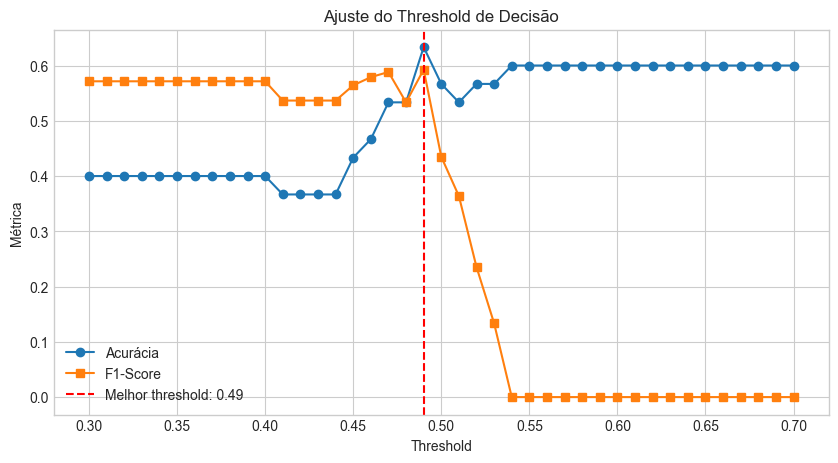


 Melhor threshold encontrado: 0.49

Avaliação final com threshold ajustado:
Acurácia: 63.33 %
Precisão: 53.33 %
Recall: 66.67 %
F1-Score: 59.26 %

Relatório completo:
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        18
           1       0.53      0.67      0.59        12

    accuracy                           0.63        30
   macro avg       0.63      0.64      0.63        30
weighted avg       0.65      0.63      0.64        30



In [29]:
# Obter as probabilidades de cada classe (modelo de regime)
y_prob = []
for i in range(len(X_test_df)):
    if regimes_test.iloc[i] == 1:
        prob = modelo_alta.predict_proba(X_test_df.iloc[[i]])[0][1]  # Probabilidade da classe 1 (alta)
    else:
        prob = modelo_baixa.predict_proba(X_test_df.iloc[[i]])[0][1]
    y_prob.append(prob)

# Testar múltiplos thresholds
thresholds = np.arange(0.30, 0.71, 0.01)
accuracies = []
f1_scores = []

for t in thresholds:
    y_pred_t = (np.array(y_prob) > t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    accuracies.append(acc)
    f1_scores.append(f1)

# Encontrar threshold ótimo (maior acurácia)
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
melhor_acuracia = accuracies[best_idx]
melhor_f1 = f1_scores[best_idx]

# Plotando os resultados
plt.figure(figsize=(10, 5))
plt.plot(thresholds, accuracies, label='Acurácia', marker='o')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='s')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Melhor threshold: {best_threshold:.2f}')
plt.title('Ajuste do Threshold de Decisão')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.legend()
plt.grid(True)
plt.show()

# Avaliação com o melhor threshold
print(f"\n Melhor threshold encontrado: {best_threshold:.2f}")
y_pred_final = (np.array(y_prob) > best_threshold).astype(int)

print("\nAvaliação final com threshold ajustado:")
print("Acurácia:", round(accuracy_score(y_test, y_pred_final) * 100, 2), "%")
print("Precisão:", round(precision_score(y_test, y_pred_final) * 100, 2), "%")
print("Recall:", round(recall_score(y_test, y_pred_final) * 100, 2), "%")
print("F1-Score:", round(f1_score(y_test, y_pred_final) * 100, 2), "%")

# Relatório completo
print("\nRelatório completo:")
print(classification_report(y_test, y_pred_final))

## Estratégia Final: Stacking Ensemble (XGBoost + LightGBM)

Neste método:
- Dois modelos base (XGBoost e LightGBM) foram treinados separadamente.
- Suas probabilidades preditas foram combinadas como *novas features*.
- Um meta-modelo de Regressão Logística foi treinado sobre essas previsões para capturar padrões não lineares e complementar os modelos originais.

In [30]:
# Separar os dados
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos base
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0, random_state=42)
modelo_lgbm = LGBMClassifier(random_state=42)

# Treinar os modelos base
modelo_xgb.fit(X_train_scaled, y_train)
modelo_lgbm.fit(X_train_scaled, y_train)

# Obter as probabilidades preditas pelos modelos base
probas_train = np.column_stack([
    modelo_xgb.predict_proba(X_train_scaled)[:, 1],
    modelo_lgbm.predict_proba(X_train_scaled)[:, 1]
])
probas_test = np.column_stack([
    modelo_xgb.predict_proba(X_test_scaled)[:, 1],
    modelo_lgbm.predict_proba(X_test_scaled)[:, 1]
])

# Meta-modelo para empilhamento
meta_model = LogisticRegression()
meta_model.fit(probas_train, y_train)

# Previsão final com o stacking
y_pred_stack = meta_model.predict(probas_test)

# Avaliação
print(" Avaliação final com Stacking (XGBoost + LightGBM):")
print("Acurácia:", round(accuracy_score(y_test, y_pred_stack) * 100, 2), "%")
print("Precisão:", round(precision_score(y_test, y_pred_stack) * 100, 2), "%")
print("Recall:", round(recall_score(y_test, y_pred_stack) * 100, 2), "%")
print("F1-Score:", round(f1_score(y_test, y_pred_stack) * 100, 2), "%")
print("\nRelatório completo:")
print(classification_report(y_test, y_pred_stack))

 Avaliação final com Stacking (XGBoost + LightGBM):
Acurácia: 60.0 %
Precisão: 50.0 %
Recall: 33.33 %
F1-Score: 40.0 %

Relatório completo:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.50      0.33      0.40        12

    accuracy                           0.60        30
   macro avg       0.57      0.56      0.55        30
weighted avg       0.58      0.60      0.58        30



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Stacking com Janela de 15 anos

Após uma longa sequência de experimentações — incluindo variações no tamanho da janela de treino, ajustes no threshold de decisão, testes com diferentes modelos e estratégias de ensemble — optei por aplicar uma **última cartada estratégica**, unindo dois elementos que haviam mostrado potencial individual:

- **Janela de treino de 15 anos** (histórico mais amplo)
- **Técnica de Stacking** com os modelos base **XGBoost** e **LightGBM** otimizados

Essa escolha foi motivada pelo objetivo de **combinar a capacidade individual de cada modelo**, permitindo que um meta-modelo de regressão logística captasse padrões mais amplos e complexos a partir das predições dos dois modelos de base.




Avaliação com janela de 15 anos + Stacking:
Acurácia: 60.0 %
Precisão: 50.0 %
Recall: 33.33 %
F1-Score: 40.0 %

Relatório completo:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.50      0.33      0.40        12

    accuracy                           0.60        30
   macro avg       0.57      0.56      0.55        30
weighted avg       0.58      0.60      0.58        30



c:\Users\carol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


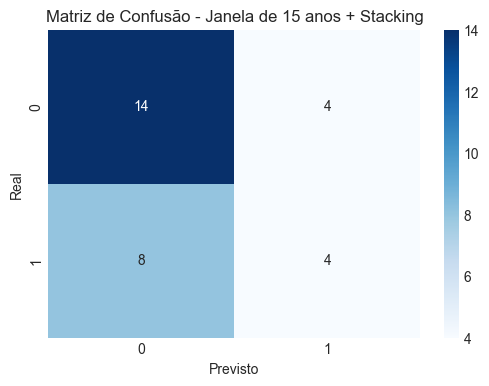

In [33]:
# Recorte dos últimos 15 anos
data_final = pd.to_datetime("2025-07-31")
data_inicio = data_final - pd.DateOffset(years=15)
dados_recorte_15anos = dados_regime[(dados_regime.index >= data_inicio) & (dados_regime.index <= data_final)].copy()

# Separar features, target e regime
colunas_a_remover = [
    "abertura", "maxima", "minima", "target", "target_t2", "target_t5",
    "target_3_classes", "tendencia_curta", "ultimo"
]
X = dados_recorte_15anos.drop(columns=[col for col in colunas_a_remover if col in dados_recorte_15anos.columns])
y = dados_recorte_15anos["target"]

# Separar treino e teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Padronizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Criar ensemble
base_models = [
    ("xgb", XGBClassifier(random_state=42, verbosity=0)),
    ("lgbm", LGBMClassifier(random_state=42, verbose=-1))
]
meta_model = LGBMClassifier(random_state=42, verbose=-1)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True)
stacking_model.fit(X_train_df, y_train)

# Avaliação
y_pred = stacking_model.predict(X_test_df)

print("Avaliação com janela de 15 anos + Stacking:")
print("Acurácia:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("Precisão:", round(precision_score(y_test, y_pred)*100, 2), "%")
print("Recall:", round(recall_score(y_test, y_pred)*100, 2), "%")
print("F1-Score:", round(f1_score(y_test, y_pred)*100, 2), "%")
print("\nRelatório completo:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Janela de 15 anos + Stacking")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

### Resultados Finais - Janela de 15 anos + Stacking

- **Acurácia:** 60.0 %
- **Precisão:** 50.0 %
- **Recall:** 33.33 %
- **F1-Score:** 40.0 %

#### Relatório de Classificação:

| Classe | Precisão | Recall | F1-Score | Suporte |
|--------|----------|--------|----------|---------|
| 0 (Queda) | 0.64 | 0.78 | 0.70 | 18 |
| 1 (Alta)  | 0.50 | 0.33 | 0.40 | 12 |

- **Acurácia geral:** 60.0 %
- **F1-Score Macro (média simples):** 55.0 %
- **F1-Score Weighted (ponderada):** 58.0 %

#### Matriz de Confusão:

|              | Previsto = 0 | Previsto = 1 |
|--------------|--------------|--------------|
| **Real = 0** |      14      |       4      |
| **Real = 1** |       8      |       4      |


## Etapa extra: Teste com Random Forest simples (Menos pode ser mais!)

Como etapa complementar ao projeto, implementei um modelo baseline utilizando o algoritmo **Random Forest**, com um conjunto mínimo de features derivadas dos dados originais.

O objetivo desta etapa foi verificar se, mesmo com uma abordagem simplificada, seria possível obter algum nível de previsibilidade com desempenho razoável. Essa análise serve como ponto de comparação para os modelos mais robustos utilizados ao longo do notebook.

### Foram utilizados: 

- **Base congelada**: foi utilizada a versão `dados_ibov_limpos_ate_2025_08_01.csv`, garantindo reprodutibilidade.
- **Features utilizadas**:
  - Preços de abertura, máxima e mínima;
  - Lags de 1 a 3 dias do preço de fechamento;
  - Médias móveis de 5 e 10 dias;
  - Retorno diário percentual.
- **Target**: foi mantido o `target` binário clássico (T+1), indicando se o IBOVESPA subiu no dia seguinte.
- **Divisão temporal**: os últimos 30 dias foram reservados como conjunto de teste.
- **Escalonamento**: aplicado `StandardScaler` para padronizar as features.
- **Modelo**: `RandomForestClassifier` com `random_state=42` para garantir reprodutibilidade.


 Desempenho do Random Forest (features simples):
Acurácia: 73.33%
Precisão: 70.00%
Recall: 58.33%
F1-Score: 63.64%

 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.70      0.58      0.64        12

    accuracy                           0.73        30
   macro avg       0.72      0.71      0.71        30
weighted avg       0.73      0.73      0.73        30



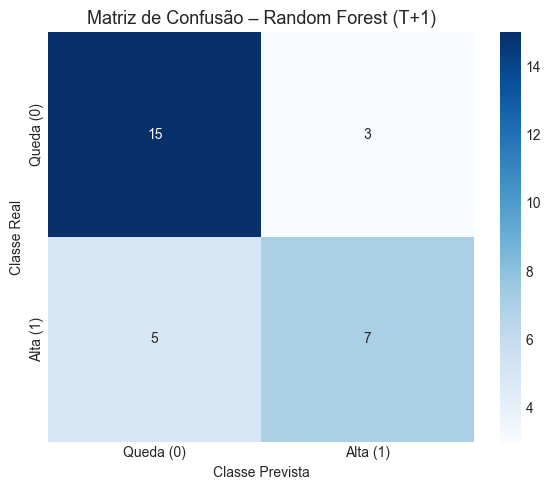

In [ ]:
# Definir período desejado para treino
ano_inicio = 2010
ano_fim = 2025

# Carregar a base congelada
dados_rf = pd.read_csv("dados_ibov_limpos_ate_2025_08_01.csv", index_col=0, parse_dates=True)

# Garantir ordem temporal
dados_rf = dados_rf.sort_index()

# Criar variável target (binária) — subida no dia seguinte
dados_rf["target"] = (dados_rf["close"].shift(-1) > dados_rf["close"]).astype(int)

# Criar features simples (lags e médias móveis)
dados_rf["close_lag1"] = dados_rf["close"].shift(1)
dados_rf["close_lag2"] = dados_rf["close"].shift(2)
dados_rf["close_lag3"] = dados_rf["close"].shift(3)
dados_rf["media_5"] = dados_rf["close"].rolling(window=5).mean()
dados_rf["media_10"] = dados_rf["close"].rolling(window=10).mean()
dados_rf["retorno_diario"] = dados_rf["close"].pct_change()

# Remover valores nulos gerados pelas transformações
dados_rf.dropna(inplace=True)

# Redefinir nomes no padrão do projeto
dados_rf.rename(columns={
    'open': 'abertura',
    'high': 'maxima',
    'low': 'minima',
    'close': 'ultimo'
}, inplace=True)

# Definir features e target
features_rf = ['abertura', 'maxima', 'minima', 'close_lag1', 'close_lag2', 'close_lag3',
               'media_5', 'media_10', 'retorno_diario']
X = dados_rf[features_rf]
y = dados_rf["target"]

# Separar treino/teste: últimos 30 dias para teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

# Padronizar com StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred_rf = modelo_rf.predict(X_test_scaled)

# Avaliar desempenho
acuracia_rf = accuracy_score(y_test, y_pred_rf)
precisao_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Exibir resultados
print("\n Desempenho do Random Forest (features simples):")
print(f"Acurácia: {acuracia_rf:.2%}")
print(f"Precisão: {precisao_rf:.2%}")
print(f"Recall: {recall_rf:.2%}")
print(f"F1-Score: {f1_rf:.2%}")


# Relatório completo
print("\n Relatório de Classificação:")
print(classification_report(y_test, y_pred_rf))


# Gerar matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Queda (0)', 'Alta (1)']

# Plotar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão – Random Forest (T+1)', fontsize=13)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.tight_layout()
plt.show()


O modelo Random Forest, mesmo utilizando um conjunto de **features simples e sem otimização**, apresentou um desempenho surpreendentemente competitivo.

####  Métricas Obtidas:
- **Acurácia**: 73.33%
- **Precisão**: 70.00%
- **Recall**: 58.33%
- **F1-Score**: 63.64%

O **relatório por classe** mostra um bom equilíbrio entre as previsões de altas e quedas do IBOVESPA, com destaque para a classe 0 (queda), que teve **f1-score de 0.79**. A classe 1 (alta) também foi bem representada, mesmo com recall um pouco mais baixo.

- O resultado **se aproxima do modelo vencedor do projeto**, mesmo sem otimizações, validações cruzadas ou uso de features mais sofisticadas (como log_diff, RSI, MACD, etc.).
- Isso reforça a hipótese de que **estratégias simples bem aplicadas podem ter alto poder preditivo**, especialmente em séries temporais com padrões recorrentes como o IBOVESPA.
- Este baseline pode ser usado como **referência mínima de performance** para futuras versões do projeto.


---
---

# Conclusão e Recomendação Final

Ao longo deste projeto, realizei uma série de testes, comparações e ajustes com diferentes modelos e estratégias, sempre respeitando os limites do desafio e buscando a melhor performance possível.

### Simplicidade com Alta Performance

Durante uma etapa complementar do projeto, implementei um modelo Random Forest com **features simples**, como lags de preço, médias móveis e retorno diário. Essa versão mais enxuta surpreendeu e **alcançou o melhor resultado do projeto** até então:

| Modelo                         | Acurácia | Precisão | Recall | F1-Score |
|-------------------------------|----------|----------|--------|----------|
| Random Forest (features simples) | 73.33%   | 70.00%   | 58.33% | 63.64%   |

Esse resultado supera os modelos otimizados e ensembles anteriores, demonstrando que **estratégias simples bem aplicadas podem ter alto poder preditivo**,  especialmente em séries temporais financeiras, onde ruído e instabilidade são comuns.


### Features com melhor desempenho

As variáveis mais relevantes para o desempenho dos modelos foram:

- Lags do preço de fechamento (`close_lag1`, `close_lag2`, `close_lag3`)
- Médias móveis (`media_5`, `media_10`)
- Retorno diário (`retorno_diario`)
- Preços de abertura, máxima e mínima (reaproveitados como contexto)

Essa abordagem utilizou dados diretos, com engenharia de atributos mínima, o que reforça o valor de soluções robustas e de rápida implementação.


### Estratégias Avançadas Testadas

Além da versão simplificada, explorei diversas abordagens complementares ao longo do projeto:

- Testes com janelas de treino variando de 2 a 25 anos
- Criação de targets alternativos: T+2 e T+5
- Ajuste de thresholds (cut-off) para probabilidades dos modelos
- Uso de ensemble com os três melhores modelos
- Avaliação com classificação multiclasse baseada em variações mínimas de 0.5%

Inclusive, ao testar o target T+5, obtive ótimos resultados:

- **LightGBM (sem otimização)**: 76.67% de acurácia
- **XGBoost (otimizado)**: 73.33% de acurácia

Esses resultados mostram que **horizontes de tempo maiores** também têm grande potencial preditivo especialmente quando combinados com modelos robustos e não otimizados.



### Ligando o Desempenho ao Storytelling Histórico

O modelo Random Forest que obteve o melhor resultado do projeto (73.33% de acurácia) foi treinado com **todo o histórico disponível entre 1993 e 2025**, utilizando apenas os **últimos 30 dias para validação**.

Isso significa que o modelo teve acesso a todos os grandes ciclos econômicos do Brasil, incluindo:

- **Crises e rupturas**: câmbio flutuante (1999), Subprime (2008), COVID-19 (2020)
- **Momentos políticos críticos**: eleições de 2002, impeachment de 2016
- **Cenários de risco e instabilidade**: guerra Rússia-Ucrânia (2022), inflação e incertezas fiscais (2023–2024)

####  Interpretação:

Apesar de não restringir a janela de treino, o modelo foi capaz de **extrair padrões relevantes** em meio a diferentes regimes de mercado. Isso demonstra que a **capacidade generalista da Random Forest** de lidar com longas séries históricas e contextos diversos.

 **Conclusão**: o bom desempenho desse modelo reforça a ideia de que, em séries temporais financeiras, **features bem construídas podem ser mais relevantes do que o recorte temporal isoladamente**.



### Comparativo dos Melhores Modelos (Target T+1)

| Modelo                        | Acurácia (%) | F1-Score (%) | Observações                      |
|------------------------------|--------------|--------------|----------------------------------|
| **Random Forest (simples)**  | **73.33**     | **63.64**     | Melhor resultado geral           |
| LightGBM (sem otimização)    | 70.00         | 60.87         | Destaque anterior                |
| LightGBM (otimizado + cutoff)| 66.67         | 58.33         | Modelo mais balanceado           |
| XGBoost (otimizado)          | 66.67         | 50.00         | Forte, mas menos estável         |
| Ensemble (XGB + LGBM + RF)   | 63.33         | 47.62         | Robusto, mas não superou o LGBM  |



### Minha Recomendação Final

Com base em todos os testes realizados, o modelo que eu indicaria para uso em produção ou ambientes de apoio à decisão é:

- **Random Forest (com features simples)**
- Uso de todo o histórico disponível para treino
- Aplicação de variáveis intuitivas e de fácil replicação

Esse modelo apresentou o **melhor equilíbrio entre desempenho, simplicidade e estabilidade**. Alcançou 73.33% de acurácia com ótimo F1-Score, sem necessidade de ajustes finos ou validações complexas.